<div id="container" style="position:relative;">
<div style="float:left"><h1> Forecasting Bakery Sales - Abi Magnall </h1></div>
<div style="position:relative; float:right"><img style="height:65px" src ="https://twomagpiesbakery.co.uk/wp-content/uploads/2020/11/logo-no-site.jpg" />
</div>
</div>

# Notebook 7 : Model 2 - Linear Regression Forecast

---

**Steps to calculate the linear regression model for a daily, weekly and monthly revenue forecast.**
 
In order for a successful linear regression model there are a few assumptions about the data that must be made, these are:

- There is a linear relationship between the dependent and independent variables
- The independent variables are independent of each other (no multicollinearity)
- Residuals are normally distributed
- Homoscedasticity: Variance of error terms are similar across the values of the independent variables

If these are not met, revenue forecasts will be less accurate. 

**Accuracy Evaluation** 
The models will then be evaluated by calculating the:
- R<sup>2</sup> - a statistical measure of fit that indicates how much variation of a daily revenue is explained by the independent variables in the regression model.
- Root Mean Squared Error (RMSE) - RMSE is a measure of how to spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. This is similar to the MAE score but larger errors are penalised more heavily. 
- Akaike Information Criterion (AIC) - evaluates how well a model fits the data, depending on the number of independent variables used. The best-fit model is the one that explains the greatest amount of variation using the fewest possible independent variables. 
- Mean Absolute Percentage Error (MAPE) value, which is the percentage of the average absolute values of error between the true revenue values and the predicted ones. 

The model with the best evaluation scores will be selected as the optimal linear regression model for the daily, weekly and monthly forecast. 

---

# Contents 

**[Executive Summary](#Executive-Summary)**

**[EDA and Data Processing - Daily Revenue](#EDA-and-Data-Processing---Daily-Revenue)**

**[1. Daily Revenue Forecast](#1.-Daily-Revenue-Forecast)**

   - [Evaluation of the Accuracy Metrics for the Models](#Evaluation-of-the-Accuracy-Metrics-for-the-Models)
   - [Evaluation of the Daily Forecast Models](#Evaluation-of-the-Daily-Forecast-Models)
   - [Exploring Reisudals of Best Daily Model](#Exploring-Reisudals-of-Best-Daily-Model)
    
**[2. Weekly Revenue Forecast](#2.-Weekly-Revenue-Forecast)**

   - [Evaluation of the Weekly Forecast Models](#Evaluation-of-the-Weekly-Forecast-Models)
   - [Exploring Reisudals of Best Weekly Model](#Exploring-Reisudals-of-Best-Weekly-Model)

**[3. Monthly Revenue Forecast](#3.-Monthly-Revenue-Forecast)**

   - [Evaluation of the Monthly Forecast Models](#Evaluation-of-the-Monthly-Forecast-Models)
   - [Exploring Reisudals of Best Monthly Model](#Exploring-Reisudals-of-Best-Monthly-Model)
    
**[Summary](#Summary)**

**[Further Improvements](#Further-Improvements)**

**[Next Steps](#Next-Steps)**
___

# Executive Summary 

- A total of 24 iterations were made for the daily, weekly and monthly forecasts. The best model for each are summarised in the table below with their MAPE scores and independent variables, which all had p-values lower than the threshold of 0.05. 
- The MAPE score was determined to be the most important accuracy metric, full discussion can be found in [Evaluation of the Accuracy Metrics for the Models](#Evaluation-of-the-Accuracy-Metrics-for-the-Models). 

|Forecast| Model | MAPE | Independent Variables | 
|:--| :- | :- | :- |
|Daily|7| 7.7 %|TAVG, Bank_Holiday, Closed_Xmas, School_Holiday, Weekend, 3D_MA_lag, 3D_Var_lag | 
|Weekly|6| 9.9 %|7W_MA_lag, Weekday|
|Monthly|9| 13.3 %|School_Holiday, Weekend, 3M_Var_lag |

---

## Importing Libraries

In [405]:
import datetime
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
import plotly.graph_objs as go
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from pandas.tseries.offsets import DateOffset
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

## Importing Custom Functions

In [2]:
import BakeryFunctions as bakery

## To Get Current Directory

In [3]:
working_directory = os.getcwd()
working_directory

'/Users/abimagnall/Documents/BrainStation/Capstone/Data'

## Importing Processed Datasets

In [4]:
# Importing the dataset
total_rev = pd.read_csv(working_directory+'/5_timeseries_data/total_revenue_encoded.csv', index_col=0)

# Converting the index to a datetime index 
total_rev.index = pd.to_datetime(total_rev.index)

# To validate it imported correctly 
display(total_rev.head())

,Total_Revenue,TAVG,PRCP,CPI_Electricity,CPI_Food,Bank_Holiday,Closed_Xmas,School_Holiday,Weekday,Weekend
2020-09-01,9780.76,24.0,0.00,107.6,102.8,0,0,0,1,0
2020-09-02,10037.55,27.0,0.00,107.6,102.8,0,0,0,1,0
2020-09-03,9419.30,31.0,0.07,107.6,102.8,0,0,0,1,0
2020-09-04,10606.15,27.0,0.08,107.6,102.8,0,0,0,1,0
2020-09-05,12922.00,23.0,0.01,107.6,102.8,0,0,0,0,1


---

# EDA and Data Processing - Daily Revenue

## Exploration into Multicolinearity
Multicolinearity is where features in a model are strongly correlated with each other. This is an issue in modelling as it reduces the precision of the estimated coefficients, which weakens the statistical power of the forecasting model. Therefore, a heatmap of the pearson correlation statistics between each column will be plotted to evaluate if there is any multicolinearity. 

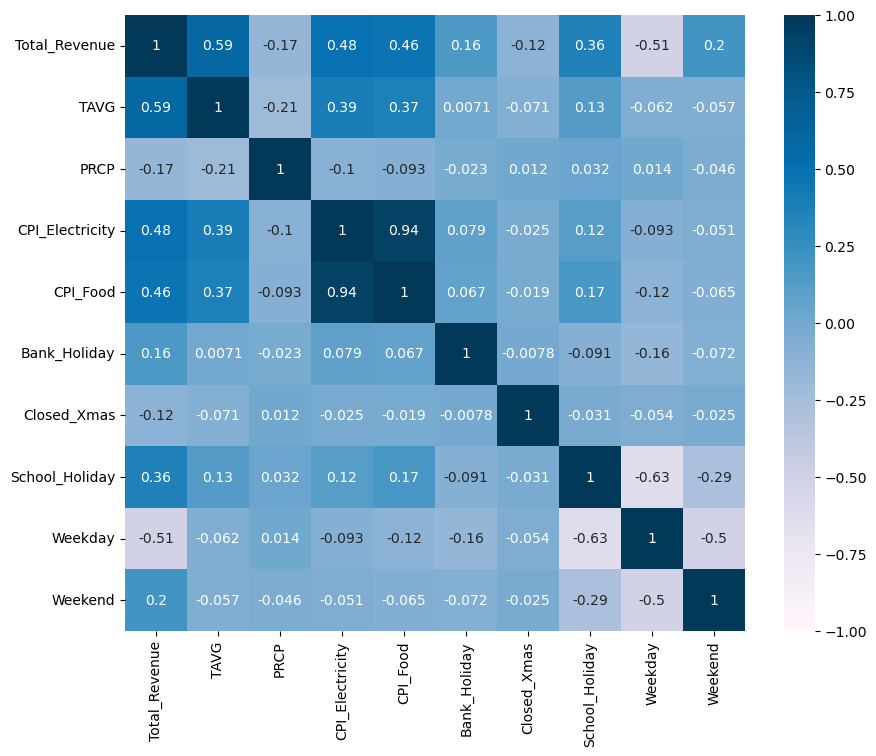

In [403]:
# To plot a heatmap of the correlation
plt.figure(figsize=(10,8))
sns.heatmap(total_rev.corr(), annot=True, vmin=-1, vmax=1, cmap='PuBu')
plt.show()

## Observations 
- `TAVG`, `CPI_Electricty`, `CPI_Food` and `Weekday` have the strongest correlations with `Total_Revenue`, therefore the hypothesis is that they will be good predictors for the daily forecast
- There is some multicolinearity, in particular between `School_Holiday` and `Weekday`, `Weekday` and `Weekend` and `CPI_Electricity` and `CPI_Food`. 

As stated earlier, multicolinearity reduces the precision of the estimated coefficients, which weakens the statistical power of the forecasting model. Therefore, `Weekday` will be dropped. 

`CPI_Food` and `CPI_Electricity` will also be removed from the model, as despite showing a strong correlation to `Total_Revenue`, the monthly data is not available until mid-way through the following month, which would make it only available to forecast the final week of revenue of each month, which makes it less useful as a predictor. 

## Data Processing

- The columns `CPI_Food`, `CPI_Electricity` and `Weekday` will be dropped 
- The 3, 7 and 20 day moving averages will be calculated, and shifted to the following week to use a statistical feautres about the data in the model. They are shifted by 7 days (the length of the test dataset) so that there is no data leakage in the test dataset

In [348]:
linear_rev = total_rev.copy()

Adding in 3, 7 and 20 moving averages using the `rev_moving_average` function. 

In [349]:
# The moving average is calculated using the rev_moving_average function 
bakery.rev_moving_average(linear_rev, 3, '3D_MA')
bakery.rev_moving_average(linear_rev, 7, '7D_MA')
bakery.rev_moving_average(linear_rev, 20, '20D_MA')

In [350]:
linear_rev.head()

,Total_Revenue,TAVG,PRCP,CPI_Electricity,CPI_Food,Bank_Holiday,Closed_Xmas,School_Holiday,Weekday,Weekend,3D_MA,7D_MA,20D_MA
2020-09-01,9780.76,24.0,0.00,107.6,102.8,0,0,0,1,0,NaN,NaN,NaN
2020-09-02,10037.55,27.0,0.00,107.6,102.8,0,0,0,1,0,NaN,NaN,NaN
2020-09-03,9419.30,31.0,0.07,107.6,102.8,0,0,0,1,0,NaN,NaN,NaN
2020-09-04,10606.15,27.0,0.08,107.6,102.8,0,0,0,1,0,9745.87,NaN,NaN
2020-09-05,12922.00,23.0,0.01,107.6,102.8,0,0,0,0,1,10021.00,NaN,NaN


In [351]:
# Dropping CPI and Weekday data that won't be included
linear_rev.drop(columns=['CPI_Electricity', 'CPI_Food', 'Weekday'], inplace=True)

In [352]:
# To move the MA data over by 7 days
for row in linear_rev.index:
    try:
        linear_rev.loc[row,'3D_MA_lag'] = linear_rev.loc[row-DateOffset(days=7),'3D_MA']
        linear_rev.loc[row,'7D_MA_lag'] = linear_rev.loc[row-DateOffset(days=7),'7D_MA']
        linear_rev.loc[row,'20D_MA_lag'] = linear_rev.loc[row-DateOffset(days=7),'20D_MA']
    except:
        continue

In [353]:
# To drop the new nan values that have been created from the moving average 
linear_rev.dropna(inplace=True)

In [354]:
# To validate it worked 
linear_rev.head()

,Total_Revenue,TAVG,PRCP,Bank_Holiday,Closed_Xmas,School_Holiday,Weekend,3D_MA,7D_MA,20D_MA,3D_MA_lag,7D_MA_lag,20D_MA_lag
2020-09-28,6780.83,21.0,0.00,0,0,0,0,9214.98,8373.18,8961.07,10503.99,9361.74,9629.16
2020-09-29,6437.72,22.0,0.01,0,0,0,0,8792.99,8104.33,8872.16,10170.28,9408.53,9573.27
2020-09-30,6900.83,24.0,0.27,0,0,0,0,7128.55,7853.81,8788.92,8895.11,9342.59,9480.96
2020-10-01,6533.37,22.0,0.59,0,0,0,0,6706.46,7856.79,8727.94,7911.36,9019.23,9353.99
2020-10-02,8090.55,23.0,0.00,0,0,0,0,6623.97,7756.81,8580.20,7434.84,8925.61,9185.34


In [355]:
# A copy of the dataset is taken with the relevant columns for audit trail purposes
linear_processed = linear_rev.drop(columns=['3D_MA', '7D_MA', '20D_MA']).copy()

In [356]:
# Splitting the train and test data
train_daily = linear_processed.loc[linear_processed.index <= '2022-09-23'].dropna().copy()
test_daily = linear_processed.loc[linear_processed.index > '2022-09-23'].copy()

In [357]:
# The total revenue and moving average columns are dropped from the independent variables list 
independent_variables = train_daily.drop(columns=['Total_Revenue']).copy()

---

# 1. Daily Revenue Forecast
## Model 1 - All Independent Variables

In [358]:
# First an empty results dataframe is created to track the accuracy of the models run
daily_model_scores = pd.DataFrame()

In [359]:
# To ensure the correct columns are in the X_test data and the constant is added
X_test_daily = test_daily.drop(columns=['Total_Revenue']).copy()

In [360]:
bakery.full_lreg(independent_variables, train_daily['Total_Revenue'], X_test_daily,
                 train_daily, test_daily, 'Model 1 - Baseline Daily Revenue',
                 test_daily['Total_Revenue'], 'baseline daily forecast')

Fitting linear regression model.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     228.7
Date:                Tue, 01 Nov 2022   Prob (F-statistic):          7.14e-204
Time:                        16:33:25   Log-Likelihood:                -6598.3
No. Observations:                 726   AIC:                         1.322e+04
Df Residuals:                     716   BIC:                         1.326e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            106.5850    255.660      0.417      0.677    -395.347     608.517
TAVG              76.8082     11.754      6.535      0.000      53.733      99.884
PRCP            -107.5786    112.409     -0.957      0.339    -328.269     113.112
Bank_Holiday    5930.9286    538.296     11.018      0.000    4874.100    6987.757
Closed_Xmas    -5271.7965   1535.880     -3.432      0.001   -8287.164   -2256.429
School_Holiday  3713.8231    199.301     18.634      0.000    3322.538    4105.108
Weekend         3878.5159    219.402     17.678      0.000    3447.768    4309.264
3D_MA_lag         -0.2207      0.052     -4.276      0.000      -0.322      -0.119
7D_MA_lag          0.5325      0.094      5.648      0.000       0.347       0.718
20D_MA_lag         0.3352      0.080      4.183      0.000       0.178       0.493
==============================================================================
Omnibus:                       13.785   Durbin-Watson:                   0.795
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.228
Skew:                           0.095   Prob(JB):                     9.04e-06
Kurtosis:                       3.855   Cond. No.                     3.36e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the baseline daily forecast is: 1764.2

The MAE between the actual and baseline daily forecast revenue is 1547.6

The MAPE between the actual and baseline daily forecast revenue is 14.1%


## Model 1 Evaluation
The initial models achieved accuracies of: 
- R<sup>2</sup> value of 0.742 - which means c.74% of the variability observed in the revenue variable is explained by model 1 
- RMSE of 1764.2 - means that the average error the the model predicts is £1764.20 off the actual
- MAE score of 1547.6 - which means on average the predicted values were £1,547.60 away from the true daily revenue
- AIC score of 1.322e+04 - This sets the baseline AIC value for other models to be compared with, better models will have a lower AIC score 
- A MAPE score of 14.1% - which means on average the model is incorrect at predicting the total revenue by 14.1% 

Looking at the p-values from the model, `PRCP` had a p-value of 0.339, which is greater than the threshold of 0.05 meaning that it is not statistically significant. Therefore, for model 2 this feature will be dropped. 

In [361]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 1, 0.742, 1764.2, 1.322e+04, '14.1%', 'All initial variables')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.742,1764.2,13220.0,14.1%,All initial variables


# Model 2 - Dropping Variables with P-Value Greater than 0.05
Dropping all with p-value greater than 0.05: `PRCP`. 

In [362]:
independent_variables_2 = independent_variables.drop(columns=['PRCP']).copy()
X_test_daily = test_daily.drop(columns=['Total_Revenue', 'PRCP']).copy()

In [363]:
bakery.full_lreg(independent_variables_2, train_daily['Total_Revenue'], X_test_daily,
                 train_daily, test_daily, 'Model 2 - Daily Revenue with Reduced Variables',
                 test_daily['Total_Revenue'], 'daily forecast')

Fitting linear regression model.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     257.2
Date:                Tue, 01 Nov 2022   Prob (F-statistic):          6.80e-205
Time:                        16:33:26   Log-Likelihood:                -6598.8
No. Observations:                 726   AIC:                         1.322e+04
Df Residuals:                     717   BIC:                         1.326e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             47.9400    248.193      0.193      0.847    -439.331     535.211
TAVG              77.9500     11.692      6.667      0.000      54.995     100.905
Bank_Holiday    5941.7726    538.146     11.041      0.000    4885.243    6998.302
Closed_Xmas    -5267.6178   1535.784     -3.430      0.001   -8282.789   -2252.446
School_Holiday  3706.4891    199.142     18.612      0.000    3315.517    4097.461
Weekend         3888.1634    219.157     17.741      0.000    3457.897    4318.430
3D_MA_lag         -0.2210      0.052     -4.283      0.000      -0.322      -0.120
7D_MA_lag          0.5323      0.094      5.646      0.000       0.347       0.717
20D_MA_lag         0.3382      0.080      4.223      0.000       0.181       0.495
==============================================================================
Omnibus:                       13.894   Durbin-Watson:                   0.794
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.268
Skew:                           0.102   Prob(JB):                     8.86e-06
Kurtosis:                       3.853   Cond. No.                     3.36e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the daily forecast is: 1761.71

The MAE between the actual and daily forecast revenue is 1547.13

The MAPE between the actual and daily forecast revenue is 14.1%


## Model 2 - Accuracy Evaluation
By dropping `PRCP` all the accuracy metrics remained the same, except for the RMSE which slightly dropped. This means that it is slightly better than the baseline model as it is less complex. All the p-values are below 0.05 suggesting they are statistically significant. 

To further improve the model, VIF will be carried to identify any multicollinearity. 

In [364]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 2, 0.742, 1761.71, 1.322e+04, '14.1%', 'Dropping PRCP')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.742,1764.20,13220.0,14.1%,All initial variables
1,2,0.742,1761.71,13220.0,14.1%,Dropping PRCP


---

# Performing VIF to Reduce Features 
For Model 2 there is a large number of independent variables included in the model, which can still lead to some multicollinearity. Therefore, a Variance Inflation Factor (VIF) test will be used to detect the remaining multicollinearity. This is done using the `vif_func` function, which utilises the `variance_inflation_factor()` method on the independent variables. Variables with large VIF scores will be removed in the next iteration. 

In [365]:
X = independent_variables_2
# vif_func is called to run the VIF test
bakery.vif_func(X)

TAVG                9.823172
Bank_Holiday        1.052386
Closed_Xmas         1.009191
School_Holiday      1.659656
Weekend             1.276295
3D_MA_lag          43.811579
7D_MA_lag         142.720214
20D_MA_lag         92.414614
dtype: float64

**Observations**: the `7D_MA_Lag` has the greatest VIF score, therefore will be removed from the next model iteration to see if this improves the VIF scores.

In [366]:
# to re-run VIF
X = independent_variables_2.drop(columns=['7D_MA_lag'])
# vif_func is called to run the VIF test
bakery.vif_func(X)

TAVG               9.775587
Bank_Holiday       1.052097
Closed_Xmas        1.005890
School_Holiday     1.589848
Weekend            1.276263
3D_MA_lag         28.653841
20D_MA_lag        33.069760
dtype: float64

**Observations**: the `20D_MA_Lag` has the greatest VIF score, suggesting there is some multicollinearity between the independent variables, therefore this will also be removed from the next model iteration to see if this improves the accuracy scores.

# Model 3 - Reducing Features

In [367]:
independent_variables_3 = independent_variables_2.drop(columns=['7D_MA_lag', '20D_MA_lag']).copy()
X_test_daily = test_daily.drop(columns=['Total_Revenue', '20D_MA_lag', '7D_MA_lag',
                                       'PRCP']).copy()

In [368]:
bakery.full_lreg(independent_variables_3, train_daily['Total_Revenue'], X_test_daily,
                 train_daily, test_daily, 'Model 3 - Daily Revenue Post VIF',
                 test_daily['Total_Revenue'], 'daily forecast')

Fitting linear regression model.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     237.1
Date:                Tue, 01 Nov 2022   Prob (F-statistic):          1.12e-166
Time:                        16:33:28   Log-Likelihood:                -6693.8
No. Observations:                 726   AIC:                         1.340e+04
Df Residuals:                     719   BIC:                         1.343e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1482.9896    253.686      5.846      0.000     984.936    1981.043
TAVG             145.6195     12.163     11.972      0.000     121.740     169.500
Bank_Holiday    5486.5361    610.881      8.981      0.000    4287.212    6685.860
Closed_Xmas    -4730.5960   1744.959     -2.711      0.007   -8156.420   -1304.772
School_Holiday  3482.0433    218.421     15.942      0.000    3053.224    3910.862
Weekend         3866.5001    249.405     15.503      0.000    3376.850    4356.150
3D_MA_lag          0.3700      0.032     11.663      0.000       0.308       0.432
==============================================================================
Omnibus:                       22.015   Durbin-Watson:                   0.767
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.242
Skew:                           0.363   Prob(JB):                     3.30e-06
Kurtosis:                       3.556   Cond. No.                     1.97e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the daily forecast is: 2210.39

The MAE between the actual and daily forecast revenue is 1409.18

The MAPE between the actual and daily forecast revenue is 10.8%


## Model 3 - Accuracy Evaluation 
Model 3 has decreased the R<sup>2</sup> value and increased the RMSE and AIC values. However, it has improved the MAPE score, suggesting it could be a more accurate model. Full discussion into comparison of the accuracy metrics is explored in [Evaluation of the Accuracy Metrics for the Models](#Evaluation-of-the-Accuracy-Metrics-for-the-Models)

In [369]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 3, 0.664, 2210.39, 1.340e+04, '10.8%', 'Dropping 7 & 20D MA')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.742,1764.20,13220.0,14.1%,All initial variables
1,2,0.742,1761.71,13220.0,14.1%,Dropping PRCP
2,3,0.664,2210.39,13400.0,10.8%,Dropping 7 & 20D MA


# Adding New Variance Features 
To try and improve the accuracy of the predictions, feature engineering will be applied to create 3 new columns. These columns willl show the variance between the calculated moving averages and the actual revenue, with a 7 day lag to ensure that no actual data is leaked into the test set. 

This is thought to improve the model accuracy as it smoothes out short-term fluctuations and provides additional information the model can learn from. 

In [370]:
# To calculate the variance
for row in linear_rev.index:
    linear_rev.loc[row,'3D_Var'] = linear_rev.loc[row,'3D_MA'] - linear_rev.loc[row,'Total_Revenue']
    linear_rev.loc[row,'7D_Var'] = linear_rev.loc[row,'7D_MA'] - linear_rev.loc[row,'Total_Revenue']
    linear_rev.loc[row,'20D_Var'] = linear_rev.loc[row,'20D_MA'] - linear_rev.loc[row,'Total_Revenue']

linear_rev.head()

,Total_Revenue,TAVG,PRCP,Bank_Holiday,Closed_Xmas,School_Holiday,Weekend,3D_MA,7D_MA,20D_MA,3D_MA_lag,7D_MA_lag,20D_MA_lag,3D_Var,7D_Var,20D_Var
2020-09-28,6780.83,21.0,0.00,0,0,0,0,9214.98,8373.18,8961.07,10503.99,9361.74,9629.16,2434.15,1592.35,2180.24
2020-09-29,6437.72,22.0,0.01,0,0,0,0,8792.99,8104.33,8872.16,10170.28,9408.53,9573.27,2355.27,1666.61,2434.44
2020-09-30,6900.83,24.0,0.27,0,0,0,0,7128.55,7853.81,8788.92,8895.11,9342.59,9480.96,227.72,952.98,1888.09
2020-10-01,6533.37,22.0,0.59,0,0,0,0,6706.46,7856.79,8727.94,7911.36,9019.23,9353.99,173.09,1323.42,2194.57
2020-10-02,8090.55,23.0,0.00,0,0,0,0,6623.97,7756.81,8580.20,7434.84,8925.61,9185.34,-1466.58,-333.74,489.65


In [371]:
# To move the variance data by 7 days to ensure no actual data leaks into the test dataset
for row in linear_rev.index:
    try:
        linear_rev.loc[row,'3D_Var_lag'] = linear_rev.loc[row-DateOffset(days=7),'3D_Var']
        linear_rev.loc[row,'7D_Var_lag'] = linear_rev.loc[row-DateOffset(days=7),'7D_Var']
        linear_rev.loc[row,'20D_Var_lag'] = linear_rev.loc[row-DateOffset(days=7),'20D_Var']
    except:
        continue

In [372]:
# Validate it worked
linear_rev.tail(12)

,Total_Revenue,TAVG,PRCP,Bank_Holiday,Closed_Xmas,School_Holiday,Weekend,3D_MA,7D_MA,20D_MA,3D_MA_lag,7D_MA_lag,20D_MA_lag,3D_Var,7D_Var,20D_Var,3D_Var_lag,7D_Var_lag,20D_Var_lag
2022-09-19,12724.135,21.0,0.00,0,0,0,0,15483.35,12348.02,12318.14,13073.85,11206.09,14294.69,2759.215,-376.115,-405.995,3197.450,1329.690,4418.290
2022-09-20,9615.100,23.0,0.00,0,0,0,0,15522.58,12754.84,12270.99,12961.20,11146.97,14067.36,5907.480,3139.740,2655.890,3085.290,1271.060,4191.450
2022-09-21,10111.170,25.0,0.00,0,0,0,0,12724.13,12717.58,12079.19,10805.92,11069.44,13856.78,2612.960,2606.410,1968.020,770.920,1034.440,3821.780
2022-09-22,9236.430,28.0,0.00,0,0,0,0,10816.80,12728.46,11995.48,9929.10,11164.71,13633.25,1580.370,3492.030,2759.050,-269.690,965.920,3434.460
2022-09-23,11410.190,25.0,0.01,0,0,0,0,9654.23,12590.98,11786.01,10036.57,11315.38,13317.60,-1755.960,1180.790,375.820,-2569.870,-1291.060,711.160
2022-09-24,17190.040,22.0,0.01,0,0,0,1,10252.60,12420.09,11556.70,10946.74,11657.11,12773.08,-6937.440,-4769.950,-5633.340,-7063.690,-6353.320,-5237.350
2022-09-25,14178.530,21.0,0.00,0,0,0,1,12612.22,12302.89,11758.29,13605.22,11895.49,12626.20,-1566.310,-1875.640,-2420.240,-2227.950,-3937.680,-3206.970
2022-09-26,9932.920,20.0,0.09,0,0,0,0,14259.59,12066.51,11952.71,15483.35,12348.02,12318.14,4326.670,2133.590,2019.790,2759.215,-376.115,-405.995
2022-09-27,9718.010,16.0,0.04,0,0,0,0,13767.16,11667.77,11928.42,15522.58,12754.84,12270.99,4049.150,1949.760,2210.410,5907.480,3139.740,2655.890
2022-09-28,8069.910,16.0,0.15,0,0,0,0,11276.49,11682.47,11945.92,12724.13,12717.58,12079.19,3206.580,3612.560,3876.010,2612.960,2606.410,1968.020


In [373]:
# A copy of the dataset with required columns is made
lin_variables = linear_rev.drop(columns= ['3D_MA', '7D_MA', '20D_MA', '3D_Var', '7D_Var',
                                               '20D_Var', 'PRCP']).copy()

In [374]:
# Splitting the train and test data
train_daily = lin_variables.loc[lin_variables.index <= '2022-09-23'].dropna().copy()
test_daily = lin_variables.loc[lin_variables.index > '2022-09-23'].copy()

# Model 4 - Adding New Variance Features

In [375]:
independent_variables_4 = train_daily.drop(columns='Total_Revenue').copy()
X_test_daily = test_daily.drop(columns=['Total_Revenue']).copy()

In [376]:
bakery.full_lreg(independent_variables_4, train_daily['Total_Revenue'], X_test_daily,
                 train_daily, test_daily, 'Model 4 - Adding New Variance Features',
                 test_daily['Total_Revenue'], 'daily forecast')

Fitting linear regression model.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     339.0
Date:                Tue, 01 Nov 2022   Prob (F-statistic):          4.85e-250
Time:                        16:33:30   Log-Likelihood:                -6424.2
No. Observations:                 719   AIC:                         1.287e+04
Df Residuals:                     709   BIC:                         1.291e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            301.0560    213.661      1.409      0.159    -118.427     720.539
TAVG              66.3549     10.077      6.585      0.000      46.570      86.139
Bank_Holiday    5202.7625    463.845     11.217      0.000    4292.089    6113.436
Closed_Xmas    -7132.0246   1322.151     -5.394      0.000   -9727.825   -4536.224
School_Holiday  2713.8776    181.635     14.941      0.000    2357.271    3070.484
Weekend         2093.8202    220.383      9.501      0.000    1661.139    2526.501
3D_MA_lag          0.0914      0.024      3.853      0.000       0.045       0.138
7D_MA_lag          0.2433      0.042      5.818      0.000       0.161       0.325
20D_MA_lag         0.3775      0.037     10.273      0.000       0.305       0.450
3D_Var_lag        -0.3196      0.023    -13.722      0.000      -0.365      -0.274
7D_Var_lag        -0.1677      0.045     -3.710      0.000      -0.256      -0.079
20D_Var_lag       -0.0335      0.034     -0.995      0.320      -0.099       0.033
==============================================================================
Omnibus:                       28.374   Durbin-Watson:                   0.723
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.306
Skew:                          -0.142   Prob(JB):                     1.47e-15
Kurtosis:                       4.483   Cond. No.                     1.62e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.47e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the daily forecast is: 991.52

The MAE between the actual and daily forecast revenue is 813.5

The MAPE between the actual and daily forecast revenue is 8.0%


## Model 4 - Accuracy Evaluation 
This model has increased the R<sup>2</sup> value, decreased the RMSE, MAE and AIC and improved the MAPE score. Therefore, model 4 is currently deemed the most accuracte model. 

The `20D_Var_lag` feature had a p-value of greater than 0.05, therefore it will be removed for the next model iteration as it is not statistically significant. 

In [377]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 4, 0.811, 991.52, 1.287e+04, '8.0%', 'Adding variance data')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.742,1764.20,13220.0,14.1%,All initial variables
1,2,0.742,1761.71,13220.0,14.1%,Dropping PRCP
2,3,0.664,2210.39,13400.0,10.8%,Dropping 7 & 20D MA
3,4,0.811,991.52,12870.0,8.0%,Adding variance data


# Model 5 - Dropping  `20D_Var_Lag`

In [378]:
independent_variables_5 = independent_variables_4.drop(columns=['20D_Var_lag']).copy()
X_test_daily = test_daily.drop(columns=['Total_Revenue', '20D_Var_lag']).copy()

In [379]:
bakery.full_lreg(independent_variables_5, train_daily['Total_Revenue'], X_test_daily,
                 train_daily, test_daily, 'Model 5 - Reducing Features',
                 test_daily['Total_Revenue'], 'daily forecast')

Fitting linear regression model.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     339.0
Date:                Tue, 01 Nov 2022   Prob (F-statistic):          4.85e-250
Time:                        16:33:31   Log-Likelihood:                -6424.2
No. Observations:                 719   AIC:                         1.287e+04
Df Residuals:                     709   BIC:                         1.291e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            301.0560    213.661      1.409      0.159    -118.427     720.539
TAVG              66.3549     10.077      6.585      0.000      46.570      86.139
Bank_Holiday    5202.7625    463.845     11.217      0.000    4292.089    6113.436
Closed_Xmas    -7132.0246   1322.151     -5.394      0.000   -9727.825   -4536.224
School_Holiday  2713.8776    181.635     14.941      0.000    2357.271    3070.484
Weekend         2093.8202    220.383      9.501      0.000    1661.139    2526.501
3D_MA_lag          0.1081      0.028      3.822      0.000       0.053       0.164
7D_MA_lag          0.2600      0.055      4.718      0.000       0.152       0.368
20D_MA_lag         0.3441      0.069      5.009      0.000       0.209       0.479
3D_Var_lag        -0.3363      0.030    -11.334      0.000      -0.395      -0.278
7D_Var_lag        -0.1844      0.036     -5.058      0.000      -0.256      -0.113
==============================================================================
Omnibus:                       28.374   Durbin-Watson:                   0.723
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.306
Skew:                          -0.142   Prob(JB):                     1.47e-15
Kurtosis:                       4.483   Cond. No.                     8.95e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.77e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the daily forecast is: 991.52

The MAE between the actual and daily forecast revenue is 813.5

The MAPE between the actual and daily forecast revenue is 8.0%


## Model 5 - Accuracy Evaluation 
This model produced the same accuracy scores as model 4, however with one less feature. Therefore this model is now deemed the best model as it achieves the same accuracy with fewer features, making it a more simple model. 

In [380]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 5, 0.811, 991.52, 1.287e+04, '8.0%', 'Removing 20D_Var_lag')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.742,1764.20,13220.0,14.1%,All initial variables
1,2,0.742,1761.71,13220.0,14.1%,Dropping PRCP
2,3,0.664,2210.39,13400.0,10.8%,Dropping 7 & 20D MA
3,4,0.811,991.52,12870.0,8.0%,Adding variance data
4,5,0.811,991.52,12870.0,8.0%,Removing 20D_Var_lag


# VIF to Reduce Features
To further try and improve the model, VIF is applied again to determine if any additional features can be dropped whilst maintaining the model accuracy. 

In [381]:
X = independent_variables_5
# vif_func is called to run the VIF test
bakery.vif_func(X)

/Users/abimagnall/opt/anaconda3/envs/bakery/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning:

divide by zero encountered in double_scalars



TAVG               9.824321
Bank_Holiday       1.061845
Closed_Xmas        1.016123
School_Holiday     1.866117
Weekend            1.726264
3D_MA_lag               inf
7D_MA_lag               inf
20D_MA_lag        91.743564
3D_Var_lag              inf
7D_Var_lag              inf
dtype: float64

**Observations**: It can be seen that `3D_MA_lag`, `7D_MA_lag`, `3D_Var_lag` and `7D_Var_lag` have VIF scores of infinity. It was expected that they would be high as they will be extremely correlated as they have been calculated on some of the same data points. 

To try and either improve the accuracy of the model or maintain the accuracy of the model but with few input features, 2 of these columns will be dropped.

The `7D_MA_lag` and `7D_Var_lag` have been selected to be dropped, as this would allow the model, when applied in the real-world, to have a larger training dataset, which would hope to improve the accuracy of the model. Once the moving averages were calculated, the new null values created were dropped. For the 3 day moving average, only 3 rows of data had to be dropped, whereas for the 7 day, 7 rows of data were. 

# Model 6 - Reducing Features 

In [382]:
independent_variables_6 = independent_variables_5.drop(columns=['7D_Var_lag',
                                                              '7D_MA_lag']).copy()
X_test_daily = test_daily.drop(columns=['Total_Revenue', '20D_Var_lag',
                                        '7D_Var_lag','7D_MA_lag']).copy()

In [383]:
bakery.full_lreg(independent_variables_6, train_daily['Total_Revenue'], X_test_daily,
                 train_daily, test_daily, 'Model 6 - Reducing Features',
                 test_daily['Total_Revenue'], 'daily forecast')

Fitting linear regression model.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     381.4
Date:                Tue, 01 Nov 2022   Prob (F-statistic):          3.55e-251
Time:                        16:33:33   Log-Likelihood:                -6424.6
No. Observations:                 719   AIC:                         1.287e+04
Df Residuals:                     710   BIC:                         1.291e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            300.6003    213.627      1.407      0.160    -118.816     720.016
TAVG              66.6907     10.068      6.624      0.000      46.923      86.458
Bank_Holiday    5196.7003    463.722     11.207      0.000    4286.271    6107.130
Closed_Xmas    -7100.9840   1321.478     -5.374      0.000   -9695.456   -4506.512
School_Holiday  2725.5666    181.123     15.048      0.000    2369.966    3081.168
Weekend         2062.7666    217.523      9.483      0.000    1635.701    2489.832
3D_MA_lag          0.3235      0.042      7.744      0.000       0.242       0.406
20D_MA_lag         0.3884      0.047      8.284      0.000       0.296       0.480
3D_Var_lag        -0.5301      0.030    -17.396      0.000      -0.590      -0.470
==============================================================================
Omnibus:                       28.382   Durbin-Watson:                   0.724
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.650
Skew:                          -0.129   Prob(JB):                     7.51e-16
Kurtosis:                       4.503   Cond. No.                     2.75e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.75e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the daily forecast is: 973.24

The MAE between the actual and daily forecast revenue is 803.74

The MAPE between the actual and daily forecast revenue is 7.9%


## Model 6 - Accuracy Evaluation 
Can see that this has caused the RMSE, R<sup>2</sup> and AIC values to be very similar, and slightly improve the MAPE score. Therefore, making this a more accurate and suitable model for the real-world scenario as it is simpler. 

In [384]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 6, 0.811, 973.24, 1.287e+04, '7.9%',
                                  'Removing 7D_MA_lag and 7D_Var_lag')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.742,1764.20,13220.0,14.1%,All initial variables
1,2,0.742,1761.71,13220.0,14.1%,Dropping PRCP
2,3,0.664,2210.39,13400.0,10.8%,Dropping 7 & 20D MA
3,4,0.811,991.52,12870.0,8.0%,Adding variance data
4,5,0.811,991.52,12870.0,8.0%,Removing 20D_Var_lag
5,6,0.811,973.24,12870.0,7.9%,Removing 7D_MA_lag and 7D_Var_lag


In [385]:
X = independent_variables_6
# vif_func is called to run the VIF test
bakery.vif_func(X)

TAVG               9.810187
Bank_Holiday       1.061604
Closed_Xmas        1.015410
School_Holiday     1.855907
Weekend            1.679281
3D_MA_lag         38.746057
20D_MA_lag        38.068756
3D_Var_lag         1.683066
dtype: float64

**Observations**: It can be seen that `20D_MA_lag` and `3D_MA_lag`are highly correlated towards one another. To try and reduce the multicolinaerity one of the columns will be dropped and the model re-run. 

# Model 7 

In [392]:
independent_variables_7 = independent_variables_6.drop(columns=[ '20D_MA_lag']).copy()
X_test_daily = test_daily.drop(columns=['Total_Revenue', '20D_Var_lag',
                                        '7D_Var_lag','7D_MA_lag','20D_MA_lag']).copy()

In [393]:
bakery.full_lreg(independent_variables_7, train_daily['Total_Revenue'], X_test_daily,
                 train_daily, test_daily, 'Model 7 - Reducing Features',
                 test_daily['Total_Revenue'], 'daily forecast')

Fitting linear regression model.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     389.1
Date:                Tue, 01 Nov 2022   Prob (F-statistic):          2.72e-238
Time:                        16:33:56   Log-Likelihood:                -6457.8
No. Observations:                 719   AIC:                         1.293e+04
Df Residuals:                     711   BIC:                         1.297e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1069.7780    201.335      5.313      0.000     674.496    1465.060
TAVG              94.7367      9.923      9.547      0.000      75.255     114.218
Bank_Holiday    4807.8490    482.781      9.959      0.000    3860.002    5755.696
Closed_Xmas    -7494.9924   1381.999     -5.423      0.000   -1.02e+04   -4781.704
School_Holiday  2292.2533    181.465     12.632      0.000    1935.982    2648.525
Weekend         1720.1084    223.479      7.697      0.000    1281.351    2158.866
3D_MA_lag          0.5941      0.027     21.790      0.000       0.541       0.648
3D_Var_lag        -0.6223      0.030    -20.961      0.000      -0.681      -0.564
==============================================================================
Omnibus:                       40.292   Durbin-Watson:                   0.674
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.203
Skew:                          -0.273   Prob(JB):                     1.74e-22
Kurtosis:                       4.745   Cond. No.                     1.97e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the daily forecast is: 1042.65

The MAE between the actual and daily forecast revenue is 850.88

The MAPE between the actual and daily forecast revenue is 7.7%


## Model 7 - Evaluation 
This iteration has produced a model with the lowest MAPE score, and with all the p-values below the threshold of 0.05, suggesting they are all statistically significant.  

In [388]:
# To add the scores to the results table 
daily_model_scores = bakery.add_results(daily_model_scores, 7, 0.793, 1042.65, 1.293e+04, '7.7%',
                                  'Removing 20D_MA_lag')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.742,1764.20,13220.0,14.1%,All initial variables
1,2,0.742,1761.71,13220.0,14.1%,Dropping PRCP
2,3,0.664,2210.39,13400.0,10.8%,Dropping 7 & 20D MA
3,4,0.811,991.52,12870.0,8.0%,Adding variance data
4,5,0.811,991.52,12870.0,8.0%,Removing 20D_Var_lag
5,6,0.811,973.24,12870.0,7.9%,Removing 7D_MA_lag and 7D_Var_lag
6,7,0.793,1042.65,12930.0,7.7%,Removing 20D_MA_lag


# Evaluation of the Accuracy Metrics for the Models 
To determine which model is the best and will be selected for daily forecasting a comparison of R<sup>2</sup>, AIC, RMSE and MAPE scores needs to explored to determine which components are the most important in developing a linear regression model for timeseries forecasting. 

- **R<sup>2</sup>** - As mentioned the R<sup>2</sup> is a measure that compares the stationary part of the model to a simple mean, and denotes how much of the revenue variance is explained by the independent variables. A high R<sup>2</sup> shows the model's variance is similar to that of the true revenue values. However, is does not indicate whether or not the model is capable at making accurate future predictions, it only shows whether the model is a good fit for the observerved values. Therefore, models that have higher R<sup>2</sup> values are better at fitting the actual total revenue, but not necessarily better at predicting future values. 

- **MAPE** - this is the proportion of the average absolute difference between predicted and actual revenue values, divided by the true value. Therefore, models with a lower MAPE score are more accurate. MAPE tends to understate the impact of big but rare errors caused by extreme values. Therefore, is best utilised in conjuction with other metrics such as RMSE. However, in the dataset the the revenue varies from £0 to c.£24,000, with a mean value of £10,000 which do not appear to be outlier results, therefore the MAPE score is not compromised. In addition to this, due to the type of data collected, it is unlikely that outlier results will be obtained but rather peaks and troughs in the revenue due to seasonal and trend factors. 

- **RMSE** - shows the square root of the mean square eroror, and penalises greater errors more. The lower the RMSE the better the model, and it can easily be explained in real terms as it is the same unit as the total revenue. However, this statistic can mask issues with low data volumes. In addition to this, having few large errors in the sum may produce a significant increase in RMSE. 

- **AIC** - The AIC score evaluates how well the model fits the data it was generated from. It is used to compare different possible models and determine which one is the best fit, depending on the number of independent variables used to build the model and how well the model reproduces the actual revenue data. The loewer the AIC score the better and AIC penalises models that use more parameters, therefore reduces overfitting. 

Therefore, it can be concluded that the MAPE score is a better metric score for determining how accurate the timeseries model is, as the R<sup>2</sup> only shows how well the model fits to the current data as opposed to how well the model can predict future revenue. Furthermore, it also treats all data points equally (despite their magnitude) which is important in capturing the seasonal trends of the actual revenue data. 

# Evaluation of the Daily Forecast Models
From the above analysis the best daily model is therefore model 7, which has the lowest MAPE score and a relatively high R<sup>2</sup>, and middle AIC and RMSE scores. 

This will then be taken forward as the best Linear Regression daily model. The model will be exported using `joblib.dump` into a `pkl` object, so that it can be recalled in the [Modelling Summary](#10_Modelling_Summary.ipynb), which reviews all the best forecasts for each timeseries model. 

In [407]:
# First the X and y values need to splitted: 
X = independent_variables_7
y = train_daily['Total_Revenue']
# Then the X_ constant needs to be added to give the intercept value
X_withconstant = sm.add_constant(X)
# The model is then instantiated using the sm.OLS method
lm_revenue = sm.OLS(y,X_withconstant)
# The model is fitted using the .fit() method
daily_revenue_model = lm_revenue.fit()

In [409]:
# To save the daily model 
joblib.dump(daily_revenue_model, 'lr_daily_model.pkl') 

['lr_daily_model.pkl']

In [416]:
# To validate it saved correctly the same summary as for model 7 should be displayed 
daily_model_test = joblib.load('lr_daily_model.pkl') 
display(daily_model_test.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     389.1
Date:                Thu, 03 Nov 2022   Prob (F-statistic):          2.72e-238
Time:                        20:01:10   Log-Likelihood:                -6457.8
No. Observations:                 719   AIC:                         1.293e+04
Df Residuals:                     711   BIC:                         1.297e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1069.7780    201.335      5.313      0.000     674.496    1465.060
TAVG              94.7367      9.923      9.547      0.000      75.255     114.218
Bank_Holiday    4807.8490    482.781      9.959      0.000    3860.002    5755.696
Closed_Xmas    -7494.9924   1381.999     -5.423      0.000   -1.02e+04   -4781.704
School_Holiday  2292.2533    181.465     12.632      0.000    1935.982    2648.525
Weekend         1720.1084    223.479      7.697      0.000    1281.351    2158.866
3D_MA_lag          0.5941      0.027     21.790      0.000       0.541       0.648
3D_Var_lag        -0.6223      0.030    -20.961      0.000      -0.681      -0.564
==============================================================================
Omnibus:                       40.292   Durbin-Watson:                   0.674
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.203
Skew:                          -0.273   Prob(JB):                     1.74e-22
Kurtosis:                       4.745   Cond. No.                     1.97e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#  Exploring Reisudals of Best Daily Model
To further evaluate the best models performance, the model residuals will be explored. For an accurate linear model, the assumptions are that: 
- Residuals are normally distributed
- Homoscedasticity: Variance of error terms are similar across the values of the independent variables

In [395]:
# The model residuals and fitted values are stored as new variables
model_resids = daily_revenue_model.resid 
model_fittedvals = daily_revenue_model.fittedvalues 

<Figure size 640x480 with 0 Axes>

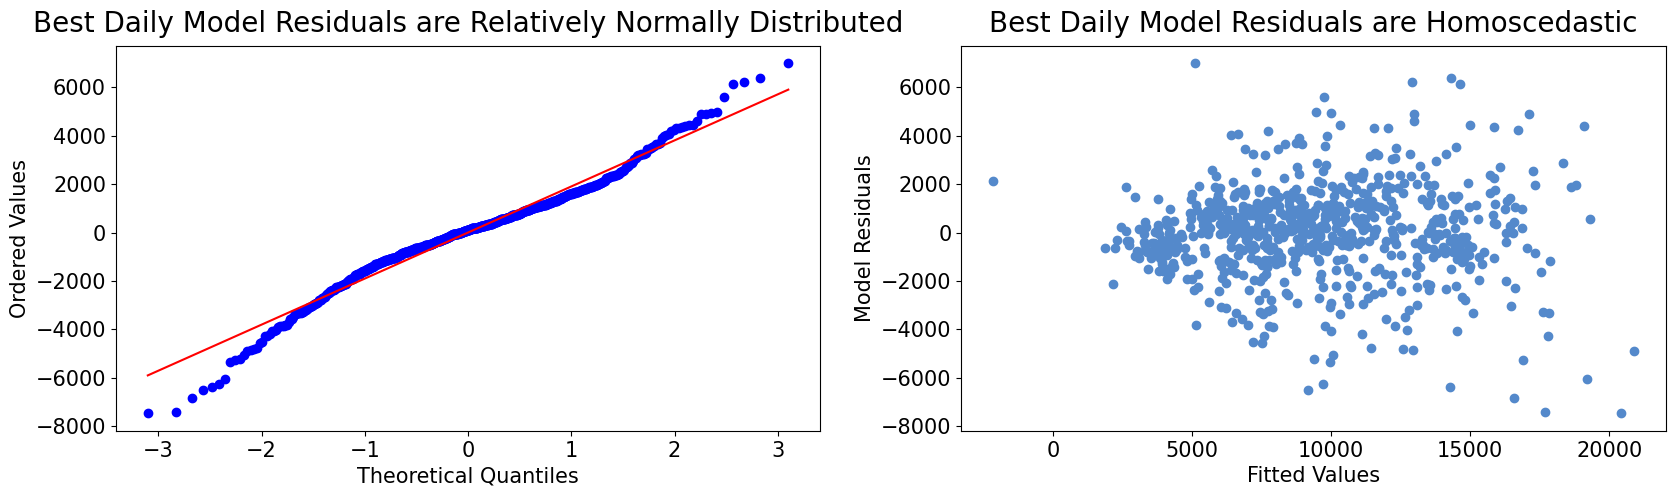

In [406]:
# To plot the residuals distribution 
plt.figure()
plt.subplots(1,2, figsize = (20,5))

# A histogram of the model residuals is plotted
plt.subplot(1,2,1)
stats.probplot(model_resids, dist='norm', plot = plt)
plt.title('Best Daily Model Residuals are Relatively Normally Distributed', fontsize=20, pad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Theoretical Quantiles', fontsize=15)
plt.ylabel('Ordered Values', fontsize=15)

# A scatter plot of the model residuals vs fitted values is plotted
plt.subplot(1,2,2)
plt.scatter(model_fittedvals, model_resids,color = bakery.light_magpie)
plt.xlabel('Fitted Values', fontsize=15)
plt.ylabel('Model Residuals', fontsize=15)
plt.title('Best Daily Model Residuals are Homoscedastic', fontsize=20, pad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

## Residual Observations
It can be seen from the above plots that the residuals are normally distributed and the fitted values vs residuals are mostly homoscedastic, with the slightest fan shape. However, this is not deemed significant and therefore the model assumptions are met. 

# 2. Weekly Revenue Forecast
## Weekly EDA and Data Processing
For the weekly forecast the following steps have to be taken: 
- Weather and CPI data is dropped as it is not suitable for forecasting 6 weeks ahead 
- Data is resampled to weekly and `Total_Revenue`, `Special Days` are summed 
- The last row of data needs to be dropped as it is not a complete week of data (only 5 days), which could cause inaccurate predictions to be made

In [297]:
total_rev_weekly = total_rev.drop(columns=['TAVG', 'PRCP', 'CPI_Electricity','CPI_Food']).copy()
# the 'W' option specifies Weekly frequency
total_rev_weekly = total_rev_weekly.resample('W').sum().round(2)
# To remove the final row of data that is not a complete week
total_rev_weekly = total_rev_weekly[:-1]
display(total_rev_weekly.tail())

,Total_Revenue,Bank_Holiday,Closed_Xmas,School_Holiday,Weekday,Weekend
2022-08-28,118277.59,0,0,7,0,0
2022-09-04,103478.40,1,0,6,0,0
2022-09-11,78442.65,0,0,0,5,2
2022-09-18,86436.14,0,0,0,5,2
2022-09-25,84465.60,0,0,0,5,2


## Exploration into Multicolinearity
Similar with the daily revenue forecast, multicolinearity needs to be determined and accounted for if present. To do this a heatmap of the correlation values is plotted. 

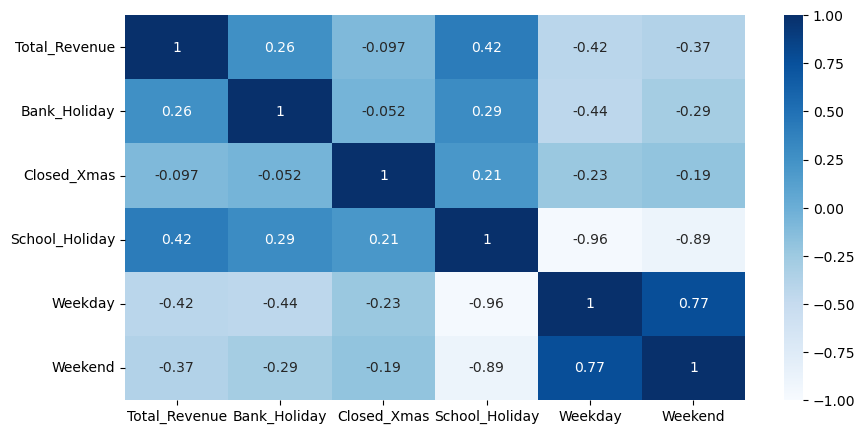

In [298]:
plt.figure(figsize=(10,5))
sns.heatmap(total_rev_weekly.corr(), annot=True, vmin=-1, vmax=1,cmap='Blues')
plt.show()

## Multicolinearity Observations
It can be seen that `Weekday` and `Weekend`, `Weekday` and `School_Holiday` and `School_Holiday` and `Weekend` have extremely high correlations with each other. To reduce this `School_Holiday` will be dropped as it has the greatest correlation with the other two variables. Not all the variables will be dropped as with the Daily

In [420]:
linear_rev = total_rev_weekly.drop(columns=['School_Holiday']).copy()

**Setting Up The Model**

The 3, 7 and 20 week moving averages will be added to the dataset and lagged by 6 weeks so that actual test total revenue does not leak into the test dataset. 

In [421]:
# The moving average is calculated using the rev_moving_average function 
bakery.rev_moving_average(linear_rev, 3, '3W_MA')
bakery.rev_moving_average(linear_rev, 7, '7W_MA')
bakery.rev_moving_average(linear_rev, 20, '20W_MA')

In [422]:
# To move the MA data over
for row in linear_rev.index:
    try:
        linear_rev.loc[row,'3W_MA_lag'] = linear_rev.loc[row-DateOffset(weeks=6),'3W_MA']
        linear_rev.loc[row,'7W_MA_lag'] = linear_rev.loc[row-DateOffset(weeks=6),'7W_MA']
        linear_rev.loc[row,'20W_MA_lag'] = linear_rev.loc[row-DateOffset(weeks=6),'20W_MA']
    except:
        continue

In [423]:
# To validate it created correctly
linear_rev.tail()

,Total_Revenue,Bank_Holiday,Closed_Xmas,Weekday,Weekend,3W_MA,7W_MA,20W_MA,3W_MA_lag,7W_MA_lag,20W_MA_lag
2022-08-28,118277.59,0,0,0,0,109668.14,101516.06,88165.74,80181.43,82346.45,75816.86
2022-09-04,103478.40,1,0,0,0,112727.74,106842.18,89886.91,83228.01,84598.11,76805.92
2022-09-11,78442.65,0,0,5,2,111714.48,108730.56,89887.88,89862.17,82137.58,78664.57
2022-09-18,86436.14,0,0,5,2,100066.21,105889.22,89681.09,100204.42,88387.72,81289.56
2022-09-25,84465.60,0,0,5,2,89452.40,102234.17,90341.89,106484.09,92893.76,83852.94


In [424]:
# Copy of the dataset is made and na values dropped
linear_processed = linear_rev.dropna().copy()

In [425]:
# Splitting the train and test data
train_weekly = linear_processed.loc[linear_processed.index <= '2022-08-14'].dropna().copy()
test_weekly = linear_processed.loc[linear_processed.index > '2022-08-14'].copy()

In [426]:
# The total revenue and moving average columns are dropped from the independent variables list 
independent_variables = train_weekly.drop(columns=['3W_MA', '7W_MA', '20W_MA', 'Total_Revenue']).copy()

# Model 1 - Weekly Forecast with All Independent Variables

In [306]:
# First an empty results dataframe is created to track the accuracy of the models run
weekly_model_scores = pd.DataFrame()

In [427]:
# The total revenue and moving average columns are dropped from the independent variables list 
independent_variables = train_weekly.drop(columns=['3W_MA', '7W_MA', '20W_MA', 'Total_Revenue']).copy()
X_test_weekly = test_weekly.drop(columns=['Total_Revenue', '3W_MA', '7W_MA', '20W_MA']).copy()

In [428]:
bakery.full_lreg(independent_variables, train_weekly['Total_Revenue'], X_test_weekly,
                 train_weekly, test_weekly, 'Model 1 - Weekly Forecast Baseline',
                 test_weekly['Total_Revenue'], 'weekly forecast')

Fitting linear regression model.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     36.69
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.05e-20
Time:                        20:05:22   Log-Likelihood:                -798.82
No. Observations:                  76   AIC:                             1614.
Df Residuals:                      68   BIC:                             1632.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         7.188e+04   4994.054     14.394      0.000    6.19e+04    8.18e+04
Bank_Holiday  5939.5460   2918.648      2.035      0.046     115.474    1.18e+04
Closed_Xmas  -1.763e+04   1.01e+04     -1.749      0.085   -3.77e+04    2480.998
Weekday      -2334.3920    910.614     -2.564      0.013   -4151.493    -517.291
Weekend      -5659.6076   1875.092     -3.018      0.004   -9401.295   -1917.920
3W_MA_lag        0.1960      0.181      1.086      0.281      -0.164       0.556
7W_MA_lag        0.8107      0.239      3.386      0.001       0.333       1.288
20W_MA_lag      -0.7905      0.119     -6.639      0.000      -1.028      -0.553
==============================================================================
Omnibus:                        0.595   Durbin-Watson:                   0.714
Prob(Omnibus):                  0.743   Jarque-Bera (JB):                0.641
Skew:                          -0.201   Prob(JB):                        0.726
Kurtosis:                       2.798   Cond. No.                     1.09e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the weekly forecast is: 14111.89

The MAE between the actual and weekly forecast revenue is 11610.11

The MAPE between the actual and weekly forecast revenue is 11.4%


In [309]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 
                                         1, 0.791, 14111.89, 1614, '11.4%', 'All initial variables')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.791,14111.89,1614,11.4%,All initial variables


# Model 2 - Dropping Variables with P-Values Greater than 0.05
Dropping variables with the greatest p-value: `3W_MA_lag`. 

In [429]:
independent_variables_2 = independent_variables.drop(columns=[ '3W_MA_lag']).copy()
X_test_weekly = test_weekly.drop(columns=['Total_Revenue',
                                          '3W_MA', '7W_MA', '20W_MA', '3W_MA_lag']).copy()

In [430]:
bakery.full_lreg(independent_variables_2, train_weekly['Total_Revenue'], X_test_weekly,
                 train_weekly, test_weekly, 'Model 2 - Weekly Forecast Removing 3W_MA_Lag',
                 test_weekly['Total_Revenue'], 'weekly forecast')

Fitting linear regression model.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     42.50
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           2.73e-21
Time:                        20:05:29   Log-Likelihood:                -799.48
No. Observations:                  76   AIC:                             1613.
Df Residuals:                      69   BIC:                             1629.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          7.35e+04   4771.947     15.403      0.000     6.4e+04     8.3e+04
Bank_Holiday  6604.1675   2857.436      2.311      0.024     903.738    1.23e+04
Closed_Xmas  -1.637e+04      1e+04     -1.634      0.107   -3.64e+04    3622.383
Weekday      -2249.5662    908.432     -2.476      0.016   -4061.838    -437.294
Weekend      -6183.9518   1814.186     -3.409      0.001   -9803.153   -2564.750
7W_MA_lag        1.0515      0.090     11.642      0.000       0.871       1.232
20W_MA_lag      -0.8561      0.103     -8.333      0.000      -1.061      -0.651
==============================================================================
Omnibus:                        1.063   Durbin-Watson:                   0.712
Prob(Omnibus):                  0.588   Jarque-Bera (JB):                0.863
Skew:                          -0.260   Prob(JB):                        0.650
Kurtosis:                       2.965   Cond. No.                     8.71e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the weekly forecast is: 14594.51

The MAE between the actual and weekly forecast revenue is 12466.81

The MAPE between the actual and weekly forecast revenue is 12.5%


In [312]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 2, 0.787, 14594.51, 1613, '12.5%', 'Dropped 3W_MA_lag')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.791,14111.89,1614,11.4%,All initial variables
1,2,0.787,14594.51,1613,12.5%,Dropped 3W_MA_lag


# Model 3 - Dropping `Closed_Xmas`
`Closed_Xmas` in the last model still had a p-value greater than 0.05, suggesting it is not statistically significant. Therefore it will be dropped from the next iteration. 

In [431]:
independent_variables_3 = independent_variables.drop(columns=['Closed_Xmas', '3W_MA_lag']).copy()
X_test_weekly = test_weekly.drop(columns=['Total_Revenue',
                                          '3W_MA', '7W_MA', '20W_MA', 'Closed_Xmas', '3W_MA_lag']).copy()

In [432]:
bakery.full_lreg(independent_variables_3, train_weekly['Total_Revenue'], X_test_weekly,
                 train_weekly, test_weekly, 'Model 3 - Weekly Forecast Removing Closed_Xmas',
                 test_weekly['Total_Revenue'], 'weekly forecast')

Fitting linear regression model.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     49.29
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.33e-21
Time:                        20:05:35   Log-Likelihood:                -800.92
No. Observations:                  76   AIC:                             1614.
Df Residuals:                      70   BIC:                             1628.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         7.284e+04   4810.860     15.140      0.000    6.32e+04    8.24e+04
Bank_Holiday  7514.4611   2835.776      2.650      0.010    1858.684    1.32e+04
Weekday      -1958.7135    901.366     -2.173      0.033   -3756.432    -160.995
Weekend      -6244.8925   1835.291     -3.403      0.001   -9905.265   -2584.520
7W_MA_lag        1.0735      0.090     11.881      0.000       0.893       1.254
20W_MA_lag      -0.8906      0.102     -8.753      0.000      -1.094      -0.688
==============================================================================
Omnibus:                        0.558   Durbin-Watson:                   0.717
Prob(Omnibus):                  0.757   Jarque-Bera (JB):                0.559
Skew:                          -0.195   Prob(JB):                        0.756
Kurtosis:                       2.845   Cond. No.                     4.31e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.31e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the weekly forecast is: 15395.97

The MAE between the actual and weekly forecast revenue is 13143.17

The MAPE between the actual and weekly forecast revenue is 13.2%


## Model 3 - Accuracy Evaluation
Dropping `Closed_Xmas` actually gave worse R<sup>2</sup>, RMSE and MAPE scores. Therefore, VIF will be performed to try and reduce input features that may be correlated, and therefore improve accuracy scores.

In [315]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 3,
                                         0.779, 15395.97, 1614, '13.2%', 'Removing Closed_Xmas')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.791,14111.89,1614,11.4%,All initial variables
1,2,0.787,14594.51,1613,12.5%,Dropped 3W_MA_lag
2,3,0.779,15395.97,1614,13.2%,Removing Closed_Xmas


# Performing VIF to Reduce Features 
For Model 3 there is a large number of independent variables included in the model, which can still lead to some multicollinearity. Therefore, a Variance Inflation Factor (VIF) test will be used to detect the remaining multicollinearity. This is done using the `vif_func` function, which utilises the `variance_inflation_factor()` method on the independent variables. Variables with large VIF scores will be removed in the next iteration. 

In [433]:
X = independent_variables_3
# vif_func is called to run the VIF test
bakery.vif_func(X)

Bank_Holiday     1.376840
Weekday          9.851082
Weekend          7.241313
7W_MA_lag       30.129846
20W_MA_lag      33.342299
dtype: float64

**Observations**: the `20W_MA_lag ` has the greatest VIF score, therefore will be removed from the next model iteration to see if this improves the VIF scores.

# Model 4 - Dropping `20W_MA_lag` 

In [434]:
independent_variables_4 = independent_variables_3.drop(columns=['20W_MA_lag']).copy()
X_test_weekly = test_weekly.drop(columns=['Total_Revenue', '3W_MA', '7W_MA', '20W_MA', 'Closed_Xmas',
                            '3W_MA_lag','20W_MA_lag']).copy()

In [435]:
bakery.full_lreg(independent_variables_4, train_weekly['Total_Revenue'], X_test_weekly,
                 train_weekly, test_weekly, 'Model 4 - Weekly Forecast Removing 20W_MA_Lag',
                 test_weekly['Total_Revenue'], 'weekly forecast')

Fitting linear regression model.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     20.57
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           2.75e-11
Time:                        20:05:49   Log-Likelihood:                -829.01
No. Observations:                  76   AIC:                             1668.
Df Residuals:                      71   BIC:                             1680.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         6.083e+04   6626.085      9.181      0.000    4.76e+04     7.4e+04
Bank_Holiday  4724.8973   4049.120      1.167      0.247   -3348.820    1.28e+04
Weekday      -2583.9820   1291.166     -2.001      0.049   -5158.494      -9.470
Weekend      -5415.1312   2633.746     -2.056      0.043   -1.07e+04    -163.590
7W_MA_lag        0.4338      0.076      5.682      0.000       0.282       0.586
==============================================================================
Omnibus:                       12.359   Durbin-Watson:                   0.341
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                5.125
Skew:                          -0.382   Prob(JB):                       0.0771
Kurtosis:                       1.983   Cond. No.                     3.06e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the weekly forecast is: 12861.2

The MAE between the actual and weekly forecast revenue is 10752.25

The MAPE between the actual and weekly forecast revenue is 10.6%


## Model 4 - Accuracy Evaluation
Despite the MAPE improving, the R<sup>2</sup> value has decreased dramatically to 0.537. 

The `Bank_Holiday` column also now has a p-value greater than 0.05, therefore for the next iteration this will be dropped. 

In [319]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 4, 0.537, 12861.2, 1668, '10.6%', 'Dropped 20D_MA_Lag')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.791,14111.89,1614,11.4%,All initial variables
1,2,0.787,14594.51,1613,12.5%,Dropped 3W_MA_lag
2,3,0.779,15395.97,1614,13.2%,Removing Closed_Xmas
3,4,0.537,12861.20,1668,10.6%,Dropped 20D_MA_Lag


# Model 5 - Dropping `Bank_Holiday`

In [436]:
independent_variables_5 = independent_variables_4.drop(columns=['Bank_Holiday']).copy()
X_test_weekly = test_weekly.drop(columns=['Total_Revenue', '3W_MA', '7W_MA', '20W_MA', 'Closed_Xmas',
                            '3W_MA_lag','20W_MA_lag', 'Bank_Holiday']).copy()

In [437]:
bakery.full_lreg(independent_variables_5, train_weekly['Total_Revenue'], X_test_weekly,
                 train_weekly, test_weekly, 'Model 5 - Weekly Forecast Removing Bank_Holiday',
                 test_weekly['Total_Revenue'], 'weekly forecast')

Fitting linear regression model.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     26.83
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           9.29e-12
Time:                        20:05:54   Log-Likelihood:                -829.73
No. Observations:                  76   AIC:                             1667.
Df Residuals:                      72   BIC:                             1677.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.458e+04   5811.562     11.112      0.000     5.3e+04    7.62e+04
Weekday    -3232.2177   1168.473     -2.766      0.007   -5561.526    -902.910
Weekend    -5042.8229   2620.906     -1.924      0.058   -1.03e+04     181.859
7W_MA_lag      0.4192      0.075      5.553      0.000       0.269       0.570
==============================================================================
Omnibus:                        8.418   Durbin-Watson:                   0.391
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                4.867
Skew:                          -0.436   Prob(JB):                       0.0877
Kurtosis:                       2.120   Cond. No.                     2.52e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the weekly forecast is: 11663.08

The MAE between the actual and weekly forecast revenue is 10286.98

The MAPE between the actual and weekly forecast revenue is 10.2%


## Model 5 - Accuracy Evaluation
Despite the MAPE improving again, the R<sup>2</sup> value has decreased again to 0.528. 

The `Weekend` column also has a p-value greater than 0.05 so will be removed from the next iteration. 

In [322]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 5, 0.528, 11663.08, 1667, 
                                         '10.2%', 'Dropped Bank_Holiday')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.791,14111.89,1614,11.4%,All initial variables
1,2,0.787,14594.51,1613,12.5%,Dropped 3W_MA_lag
2,3,0.779,15395.97,1614,13.2%,Removing Closed_Xmas
3,4,0.537,12861.20,1668,10.6%,Dropped 20D_MA_Lag
4,5,0.528,11663.08,1667,10.2%,Dropped Bank_Holiday


# Model 6 - Dropping `Weekend`

In [438]:
independent_variables_6 = independent_variables_5.drop(columns=['Weekend']).copy()
X_test_weekly = test_weekly.drop(columns=['Total_Revenue', '3W_MA', '7W_MA', '20W_MA', 'Closed_Xmas',
                            '3W_MA_lag','20W_MA_lag', 'Bank_Holiday', 'Weekend']).copy()

In [439]:
bakery.full_lreg(independent_variables_6, train_weekly['Total_Revenue'], X_test_weekly,
                 train_weekly, test_weekly, 'Model 6 - Weekly Forecast Removing Weekend',
                 test_weekly['Total_Revenue'], 'weekly forecast')

Fitting linear regression model.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     37.03
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           7.92e-12
Time:                        20:06:10   Log-Likelihood:                -831.64
No. Observations:                  76   AIC:                             1669.
Df Residuals:                      73   BIC:                             1676.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.515e+04   5910.362     11.023      0.000    5.34e+04    7.69e+04
Weekday    -4983.3767    746.236     -6.678      0.000   -6470.624   -3496.130
7W_MA_lag      0.4078      0.077      5.321      0.000       0.255       0.561
==============================================================================
Omnibus:                        4.937   Durbin-Watson:                   0.442
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                2.902
Skew:                          -0.269   Prob(JB):                        0.234
Kurtosis:                       2.208   Cond. No.                     2.52e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the weekly forecast is: 11570.81

The MAE between the actual and weekly forecast revenue is 10020.12

The MAPE between the actual and weekly forecast revenue is 9.9%


## Model 6 - Accuracy Evaluation
Again reducing the features has improved the MAPE score, but decreased the R<sup>2</sup> value. 

The determination of which model is better (better R<sup>2</sup> vs MAPE score) will be evaluated in the [Evaluation of the Models](#Evaluation-of-the-Models) section. 

In [325]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 6, 0.504, 11570.81, 1669, '9.9%', 'Dropped Weekend')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.791,14111.89,1614,11.4%,All initial variables
1,2,0.787,14594.51,1613,12.5%,Dropped 3W_MA_lag
2,3,0.779,15395.97,1614,13.2%,Removing Closed_Xmas
3,4,0.537,12861.20,1668,10.6%,Dropped 20D_MA_Lag
4,5,0.528,11663.08,1667,10.2%,Dropped Bank_Holiday
5,6,0.504,11570.81,1669,9.9%,Dropped Weekend


# Adding New Variance Features
- Similar to the daily forecast, to try and improve the accuracy of the predictions, feature engineering will be applied to create 3 new columns. These columns willl show the variance between the calculated moving averages and the actual revenue, with a 6 week lag to ensure that no actual data is leaked into the test set. 

In [440]:
for row in linear_processed.index:
    linear_processed.loc[row,'3W_Var'] = linear_processed.loc[row,'3W_MA'] - linear_processed.loc[row,'Total_Revenue']
    linear_processed.loc[row,'7W_Var'] = linear_processed.loc[row,'7W_MA'] - linear_processed.loc[row,'Total_Revenue']
    linear_processed.loc[row,'20W_Var'] = linear_processed.loc[row,'20W_MA'] - linear_processed.loc[row,'Total_Revenue']

linear_processed.head()

,Total_Revenue,Bank_Holiday,Closed_Xmas,Weekday,Weekend,3W_MA,7W_MA,20W_MA,3W_MA_lag,7W_MA_lag,20W_MA_lag,3W_Var,7W_Var,20W_Var
2021-03-07,27155.95,0,0,5,2,25011.21,22382.30,34408.72,23360.33,32634.45,45384.89,-2144.74,-4773.65,7252.77
2021-03-14,28698.05,0,0,5,2,27602.74,23735.49,33031.76,19595.52,30668.29,43246.19,-1095.31,-4962.56,4333.71
2021-03-21,29639.92,0,0,5,2,28286.07,24961.29,31409.26,20224.94,28081.83,41181.90,-1353.85,-4678.63,1769.34
2021-03-28,33834.22,0,0,5,2,28497.97,25927.89,29224.79,21319.61,24330.07,38953.67,-5336.25,-7906.33,-4609.43
2021-04-04,49890.95,1,0,3,0,30724.06,27765.97,28843.68,21074.25,21917.31,36992.12,-19166.89,-22124.98,-21047.27


In [441]:
# To move the MA data over
for row in linear_rev.index:
    try:
        linear_processed.loc[row,'3W_Var_lag'] = linear_processed.loc[row-DateOffset(weeks=6),'3W_Var']
        linear_processed.loc[row,'7W_Var_lag'] = linear_processed.loc[row-DateOffset(weeks=6),'7W_Var']
        linear_processed.loc[row,'20W_Var_lag'] = linear_processed.loc[row-DateOffset(weeks=6),'20W_Var']
    except:
        continue

In [442]:
# To validate it worked
linear_processed.head()

,Total_Revenue,Bank_Holiday,Closed_Xmas,Weekday,Weekend,3W_MA,7W_MA,20W_MA,3W_MA_lag,7W_MA_lag,20W_MA_lag,3W_Var,7W_Var,20W_Var,3W_Var_lag,7W_Var_lag,20W_Var_lag
2021-03-07,27155.95,0,0,5,2,25011.21,22382.30,34408.72,23360.33,32634.45,45384.89,-2144.74,-4773.65,7252.77,NaN,NaN,NaN
2021-03-14,28698.05,0,0,5,2,27602.74,23735.49,33031.76,19595.52,30668.29,43246.19,-1095.31,-4962.56,4333.71,NaN,NaN,NaN
2021-03-21,29639.92,0,0,5,2,28286.07,24961.29,31409.26,20224.94,28081.83,41181.90,-1353.85,-4678.63,1769.34,NaN,NaN,NaN
2021-03-28,33834.22,0,0,5,2,28497.97,25927.89,29224.79,21319.61,24330.07,38953.67,-5336.25,-7906.33,-4609.43,NaN,NaN,NaN
2021-04-04,49890.95,1,0,3,0,30724.06,27765.97,28843.68,21074.25,21917.31,36992.12,-19166.89,-22124.98,-21047.27,NaN,NaN,NaN


In [443]:
# To drop the columns not required for the model 
lin_variables = linear_processed.drop(columns= ['3W_MA', '7W_MA', '20W_MA', '3W_Var', '7W_Var',
                                               '20W_Var']).copy()

In [444]:
# Splitting the train and test data
train_weekly = lin_variables.loc[lin_variables.index <= '2022-08-14'].dropna().copy()
test_weekly = lin_variables.loc[lin_variables.index > '2022-08-14'].copy()

# Model 7 - Adding Variance Features

In [445]:
independent_variables_7 = train_weekly.drop(columns='Total_Revenue').copy()
X_test_weekly = test_weekly.drop(columns=['Total_Revenue']).copy()

In [446]:
bakery.full_lreg(independent_variables_7, train_weekly['Total_Revenue'], X_test_weekly,
                 train_weekly, test_weekly, 'Model 7 - Weekly Forecast Adding Variances',
                 test_weekly['Total_Revenue'], 'weekly forecast')

Fitting linear regression model.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     35.27
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           4.28e-20
Time:                        20:06:26   Log-Likelihood:                -718.54
No. Observations:                  70   AIC:                             1455.
Df Residuals:                      61   BIC:                             1475.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         8.546e+04   4770.679     17.914      0.000    7.59e+04     9.5e+04
Bank_Holiday  7387.8801   2407.667      3.068      0.003    2573.452    1.22e+04
Closed_Xmas  -1.714e+04   7994.754     -2.144      0.036   -3.31e+04   -1150.912
Weekday      -2527.7165    773.865     -3.266      0.002   -4075.155    -980.278
Weekend      -5880.4642   1582.849     -3.715      0.000   -9045.567   -2715.362
3W_MA_lag       -0.0546      0.080     -0.681      0.498      -0.215       0.106
7W_MA_lag        0.4712      0.094      4.998      0.000       0.283       0.660
20W_MA_lag      -0.3643      0.061     -5.927      0.000      -0.487      -0.241
3W_Var_lag      -0.0981      0.080     -1.220      0.227      -0.259       0.063
7W_Var_lag       0.4277      0.108      3.978      0.000       0.213       0.643
20W_Var_lag     -0.4078      0.044     -9.349      0.000      -0.495      -0.321
==============================================================================
Omnibus:                        3.259   Durbin-Watson:                   0.980
Prob(Omnibus):                  0.196   Jarque-Bera (JB):                3.038
Skew:                           0.507   Prob(JB):                        0.219
Kurtosis:                       2.877   Cond. No.                     5.85e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.95e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the weekly forecast is: 15164.45

The MAE between the actual and weekly forecast revenue is 13435.25

The MAPE between the actual and weekly forecast revenue is 13.7%


## Model 7 - Accuracy Evaluation 
- This has increased the R<sup>2</sup>  value and decreased the AIC score which suggests an improvement 
- However, it has increased the MAPE score slightly 

The columns `3W_MA_lag` and `3W_Var_lag` have p-values greater than 0.05, therefore will be removed from the next iteration of the model. 

In [333]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 7,
                                         0.822, 15164.45, 1455, '13.7%', 'Added variance columns')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.791,14111.89,1614,11.4%,All initial variables
1,2,0.787,14594.51,1613,12.5%,Dropped 3W_MA_lag
2,3,0.779,15395.97,1614,13.2%,Removing Closed_Xmas
3,4,0.537,12861.20,1668,10.6%,Dropped 20D_MA_Lag
4,5,0.528,11663.08,1667,10.2%,Dropped Bank_Holiday
5,6,0.504,11570.81,1669,9.9%,Dropped Weekend
6,7,0.822,15164.45,1455,13.7%,Added variance columns


# Model 8 - Removing    `3W_MA_lag` and `3W_Var_lag` 

In [447]:
independent_variables_8 = independent_variables_7.drop(columns=['3W_MA_lag', '3W_Var_lag']).copy()
X_test_weekly= X_test_weekly.drop(columns=['3W_MA_lag', '3W_Var_lag']).copy()

In [448]:
bakery.full_lreg(independent_variables_8, train_weekly['Total_Revenue'], X_test_weekly,
                 train_weekly, test_weekly, 'Model 8 - Weekly Forecast Reducing Variables',
                 test_weekly['Total_Revenue'], 'weekly forecast')

Fitting linear regression model.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     40.19
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.03e-20
Time:                        20:06:31   Log-Likelihood:                -719.09
No. Observations:                  70   AIC:                             1454.
Df Residuals:                      62   BIC:                             1472.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         8.406e+04   4552.025     18.467      0.000     7.5e+04    9.32e+04
Bank_Holiday  6927.5351   2360.931      2.934      0.005    2208.102    1.16e+04
Closed_Xmas  -1.805e+04   7938.086     -2.274      0.026   -3.39e+04   -2183.875
Weekday      -2546.1173    773.417     -3.292      0.002   -4092.157   -1000.078
Weekend      -5581.8909   1552.940     -3.594      0.001   -8686.173   -2477.609
7W_MA_lag        0.4036      0.048      8.347      0.000       0.307       0.500
20W_MA_lag      -0.3346      0.066     -5.055      0.000      -0.467      -0.202
7W_Var_lag       0.3388      0.080      4.230      0.000       0.179       0.499
20W_Var_lag     -0.3994      0.039    -10.139      0.000      -0.478      -0.321
==============================================================================
Omnibus:                        2.736   Durbin-Watson:                   0.936
Prob(Omnibus):                  0.255   Jarque-Bera (JB):                2.650
Skew:                           0.460   Prob(JB):                        0.266
Kurtosis:                       2.749   Cond. No.                     3.00e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.28e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the weekly forecast is: 14793.45

The MAE between the actual and weekly forecast revenue is 12652.13

The MAPE between the actual and weekly forecast revenue is 12.7%


## Model 8 - Accuracy Evaluation 
- This has slgihtly decreased the the R<sup>2</sup> value but has also decreased the MAPE score from model 7. This has one of the highest R<sup>2</sup> scores, but also one of the worse MAPE scores out of the models. Therefore, the different accuracy metrics will need to be evaluated to determine which is the most important metric in determining the accuracy of timeseries models. 

In [336]:
# To add the scores to the results table 
weekly_model_scores = bakery.add_results(weekly_model_scores, 8, 0.819, 14793.45, 1454,
                                         '12.7%', 'Removed 3W_MA_lag & 3W_Var_lag')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.791,14111.89,1614,11.4%,All initial variables
1,2,0.787,14594.51,1613,12.5%,Dropped 3W_MA_lag
2,3,0.779,15395.97,1614,13.2%,Removing Closed_Xmas
3,4,0.537,12861.20,1668,10.6%,Dropped 20D_MA_Lag
4,5,0.528,11663.08,1667,10.2%,Dropped Bank_Holiday
5,6,0.504,11570.81,1669,9.9%,Dropped Weekend
6,7,0.822,15164.45,1455,13.7%,Added variance columns
7,8,0.819,14793.45,1454,12.7%,Removed 3W_MA_lag & 3W_Var_lag


# Evaluation of the Weekly Forecast Models
As explored in the [Evaluation of the Accuracy Metrics for the Models](#Evaluation-of-the-Accuracy-Metrics-for-the-Models), it was concluded that the MAPE score was more important that the R<sup>2</sup> value. 

**Model 6 has been selected as the most accurate model, due to having a lower MAPE score**. This was decided over model 8, which has the greatest R<sup>2</sup> score and relatively good MAPE score, as the R<sup>2</sup> only shows how well the model fits to the current data as opposed to how well the model can predict future revenue. 

Therefore, model 6 is selected as the most accuracte model for forecasting weekly revenue. This will be saved to a new `pkl` object, so that it can be evaluated in the [Modelling Summary Notebook](#10_Modelling_Summary.ipynb).

In [456]:
independent_variables_6 = independent_variables_5.drop(columns=['Bank_Holiday']).copy()
# First the X and y values need to splitted: 
X = independent_variables_6
y = train['Total_Revenue']
# Then the X_ constant needs to be added to give the intercept value
X_withconstant = sm.add_constant(X)
# The model is then instantiated using the sm.OLS method
lm_revenue = sm.OLS(y,X_withconstant)
# The model is fitted using the .fit() method
weekly_revenue_model = lm_revenue.fit()

In [457]:
# To save the daily model 
joblib.dump(weekly_revenue_model, 'lr_weekly_model.pkl') 

['lr_weekly_model.pkl']

In [458]:
# To validate it saved correctly the same summary as for model 6 should be displayed 
weekly_model_test = joblib.load('lr_weekly_model.pkl') 
display(weekly_model_test.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     37.03
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           7.92e-12
Time:                        20:08:55   Log-Likelihood:                -831.64
No. Observations:                  76   AIC:                             1669.
Df Residuals:                      73   BIC:                             1676.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.515e+04   5910.362     11.023      0.000    5.34e+04    7.69e+04
Weekday    -4983.3767    746.236     -6.678      0.000   -6470.624   -3496.130
7W_MA_lag      0.4078      0.077      5.321      0.000       0.255       0.561
==============================================================================
Omnibus:                        4.937   Durbin-Watson:                   0.442
Prob(Omnibus):                  0.085   Jarque-Bera (JB):                2.902
Skew:                          -0.269   Prob(JB):                        0.234
Kurtosis:                       2.208   Cond. No.                     2.52e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Exploring Reisudals of Best Weekly Model
As stated in the introduction, for an accurate linear model, the assumptions are that:

- Residuals are normally distributed
- Homoscedasticity: Variance of error terms are similar across the values of the independent variables

*First the model is re-instantiated and fitted.*

In [459]:
# The model residuals and fitted values are stored as new variables
model_resids = weekly_revenue_model.resid 
model_fittedvals = weekly_revenue_model.fittedvalues 

<Figure size 640x480 with 0 Axes>

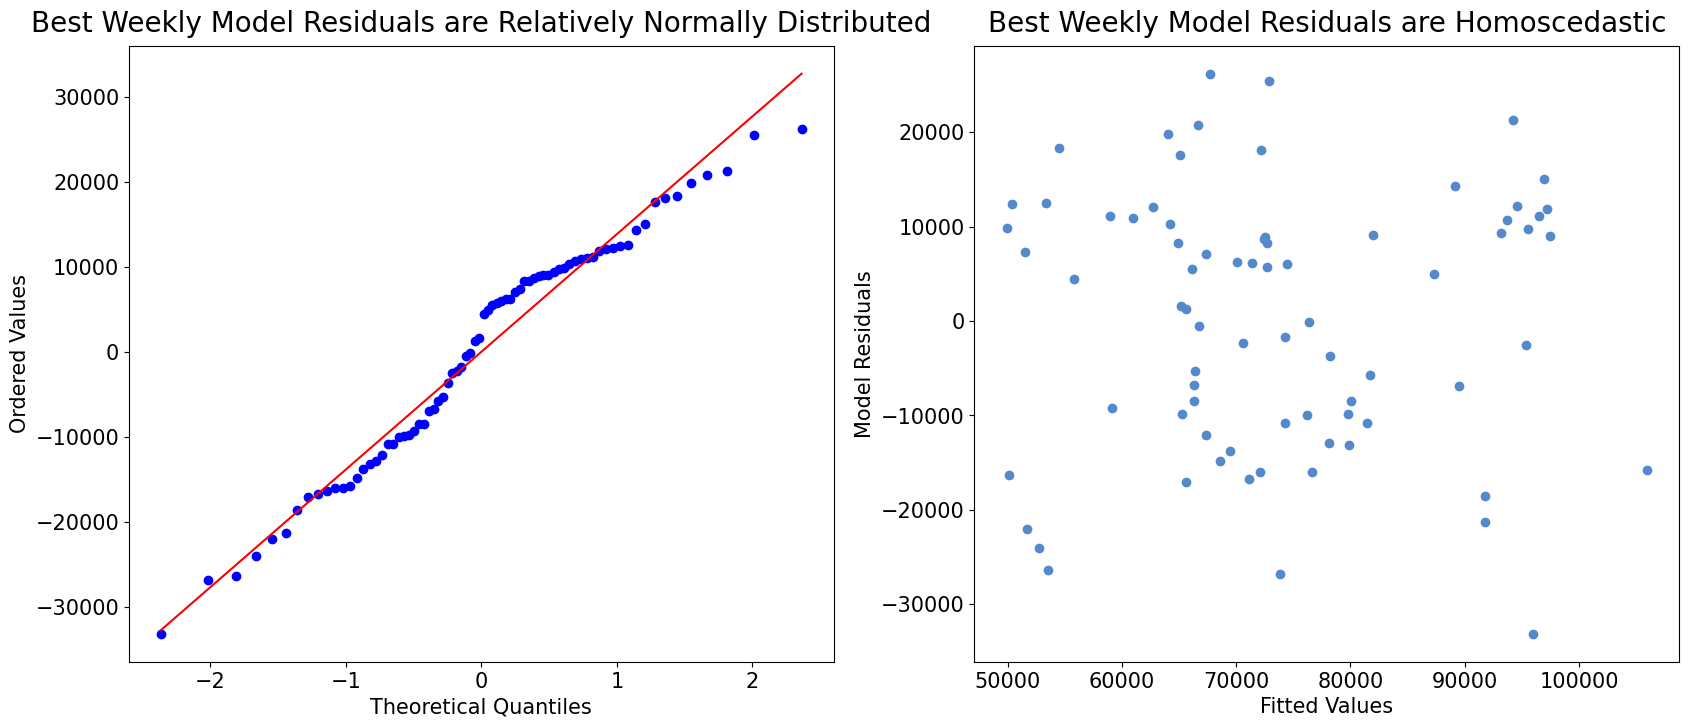

In [460]:
# To plot the residuals distribution 
plt.figure()
plt.subplots(1,2, figsize = (20,8))

# A histogram of the model residuals is plotted
plt.subplot(1,2,1)
stats.probplot(model_resids, dist='norm', plot = plt)
plt.title('Best Weekly Model Residuals are Relatively Normally Distributed', fontsize=20, pad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Theoretical Quantiles', fontsize=15)
plt.ylabel('Ordered Values', fontsize=15)

# A scatter plot of the model residuals vs fitted values is plotted
plt.subplot(1,2,2)
plt.scatter(model_fittedvals, model_resids,color = bakery.light_magpie)
plt.xlabel('Fitted Values', fontsize=15)
plt.ylabel('Model Residuals', fontsize=15)
plt.title('Best Weekly Model Residuals are Homoscedastic', fontsize=20, pad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

## Weekly Residual Observations
It can be seen from the above plots that the fitted values vs residuals are homoscedastic, which fits the assumptions made. 

However, the residual distribution is not completely normal, and has a left-hand skew. This is could be due to there being too few data points in the train data set, and increasing the data size would improve this. Another suggestion is that perhaps the model is not as accurate as the errors the model makes are not consistent across variables and observations (i.e. the errors are not random). 

Through external research it is deemed that the residuals not being completely normally distributed does not mean the model is definitely inaccurate and could be due to the sample size used<sup> [1]</sup>. To test this theory and further improve the model, this should be re-run with a larger data size. 

# 3. Monthly Revenue Forecast
## Monthly EDA and Data Processing
For the monthly forecast the following steps have to be taken: 
- Weather and CPI data is dropped as it is not suitable for forecasting 6 months ahead 
- Data is resampled to monthly and `Total_Revenue`, `Special Days` are summed 

In [155]:
total_rev_monthly = total_rev.drop(columns=['TAVG', 'PRCP', 'CPI_Electricity','CPI_Food']).copy()
# Resampled to monthly
total_rev_monthly = total_rev_monthly.resample('MS').sum().round(2)
display(total_rev_monthly.tail())

,Total_Revenue,Bank_Holiday,Closed_Xmas,School_Holiday,Weekday,Weekend
2022-05-01,332789.82,1,0,4,19,7
2022-06-01,351262.48,2,0,3,19,6
2022-07-01,422977.42,0,0,9,16,6
2022-08-01,496394.56,2,0,29,0,0
2022-09-01,350491.42,0,0,4,20,6


## Exploration into Multicolinearity
Similar with the daily and weekly revenue forecast, multicolinearity needs to be determined and accounted for if present. To do this a heatmap of the correlation values is plotted. 

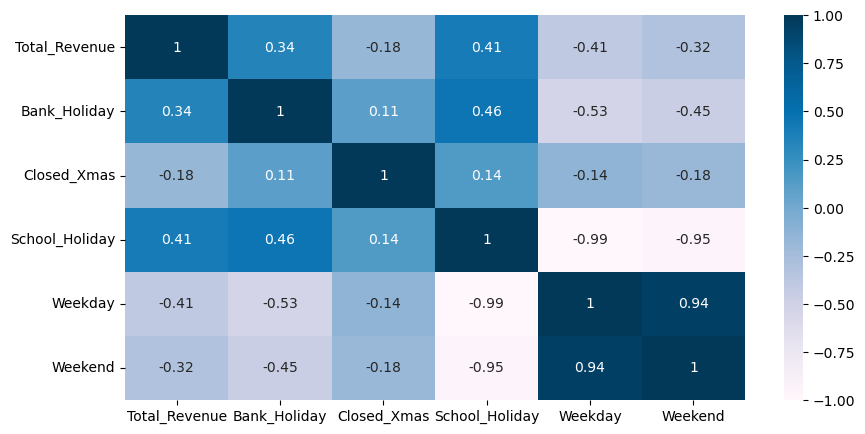

In [461]:
plt.figure(figsize=(10,5))
sns.heatmap(total_rev_monthly.corr(), annot=True, vmin=-1, vmax=1,cmap='PuBu')
plt.show()

## Observations
It can be seen that `Weekday` and `Weekend`, `Weekday` and `School_Holiday` and `School_Holiday` and `Weekend` have extremely high correlations with each other. 

However, for the purposes of the monthly forecasting, as there is less data to train the model, all the features will be kept in the initial model and have the p-value evaluated to determine if they statistically significant or not. 

In [221]:
# Copy of the dataset is taken for audit trail purposes
linear_processed = total_rev_monthly.copy()
# Splitting the train and test data
train_monthly = linear_processed.loc[linear_processed.index <= '2022-03-01'].dropna().copy()
test_monthly = linear_processed.loc[linear_processed.index > '2022-03-01'].copy()

# Model 1 - Special Days
For the first model, only the special days will be evaluated as the baseline model. By adding additional features of a moving average, this reduces the dataset size and therefore the likelihood of the model accurately predicting the monthly revenue. 

In [268]:
# First an empty results dataframe is created to track the accuracy of the models run
monthly_model_scores = pd.DataFrame()

In [222]:
# The total revenue and moving average columns are dropped from the independent variables list 
independent_variables = train_monthly.drop(columns=['Total_Revenue']).copy()
X_test_monthly = test_monthly.drop(columns=['Total_Revenue']).copy()

In [166]:
bakery.full_lreg(independent_variables, train_monthly['Total_Revenue'], X_test_monthly,
                 train_monthly, test_monthly, 'Model 1 - Baseline Monthly Model with Special Days',
                 test_monthly['Total_Revenue'], 'monthly forecast')

Fitting linear regression model.



/Users/abimagnall/opt/anaconda3/envs/bakery/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=19



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     1.227
Date:                Tue, 01 Nov 2022   Prob (F-statistic):              0.351
Time:                        14:36:03   Log-Likelihood:                -241.13
No. Observations:                  19   AIC:                             494.3
Df Residuals:                      13   BIC:                             499.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.133e+06   9.81e+05     -1.156      0.269   -3.25e+06    9.86e+05
Bank_Holiday    3.642e+04   3.85e+04      0.946      0.361   -4.67e+04     1.2e+05
Closed_Xmas    -4.363e+04   7.47e+04     -0.584      0.569   -2.05e+05    1.18e+05
School_Holiday  5.149e+04   3.33e+04      1.547      0.146   -2.04e+04    1.23e+05
Weekday         4.048e+04    3.9e+04      1.039      0.318   -4.37e+04    1.25e+05
Weekend         5.643e+04   3.12e+04      1.808      0.094    -1.1e+04    1.24e+05
==============================================================================
Omnibus:                        1.832   Durbin-Watson:                   0.648
Prob(Omnibus):                  0.400   Jarque-Bera (JB):                1.438
Skew:                          -0.636   Prob(JB):                        0.487
Kurtosis:                       2.553   Cond. No.                         869.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the monthly forecast is: 105224.75

The MAE between the actual and monthly forecast revenue is 100004.11

The MAPE between the actual and monthly forecast revenue is 26.7%


## Model 1 Evaluation
The initial models achieved accuracies of: 
- R<sup>2</sup> value of 0.709
- RMSE of 105224.75
- AIC score of 494.3 - This sets the baseline AIC value for other models to be compared with, better models will have a lower AIC score 
- A MAPE score of 26.7% 

Looking at the p-values from the model, all of them are greater than the threshold value of 0.05. Therefore, the next iteration of the model the feature with the greatest p-values, `Closed_Xmas`, will be dropped. 

In [269]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 1, 0.709, 105224.75, 494.3 ,
                                          '26.7%', 'All special days')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.709,105224.75,494.3,26.7%,All special days


# Model 2 - Dropping `Closed_Xmas` 

In [223]:
# The chosen columns are dropped 
independent_variables_2 = independent_variables.drop(columns=[ 'Closed_Xmas']).copy()
X_test_monthly = test_monthly.drop(columns=['Total_Revenue',  'Closed_Xmas']).copy()

In [210]:
bakery.full_lreg(independent_variables_2, train_monthly['Total_Revenue'], X_test_monthly,
                 train_monthly, test_monthly, 'Model 2 - Monthly Forecast Dropping Closed_Xmas',
                 test_monthly['Total_Revenue'], 'monthly forecast')

Fitting linear regression model.



/Users/abimagnall/opt/anaconda3/envs/bakery/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=19



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     1.521
Date:                Tue, 01 Nov 2022   Prob (F-statistic):              0.250
Time:                        15:27:28   Log-Likelihood:                -241.38
No. Observations:                  19   AIC:                             492.8
Df Residuals:                      14   BIC:                             497.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.136e+06   9.57e+05     -1.186      0.255   -3.19e+06    9.18e+05
Bank_Holiday    3.307e+04   3.72e+04      0.890      0.388   -4.66e+04    1.13e+05
School_Holiday  5.147e+04   3.25e+04      1.584      0.136   -1.82e+04    1.21e+05
Weekday         3.939e+04    3.8e+04      1.037      0.317   -4.21e+04    1.21e+05
Weekend         5.943e+04      3e+04      1.978      0.068   -5015.565    1.24e+05
==============================================================================
Omnibus:                        1.648   Durbin-Watson:                   0.563
Prob(Omnibus):                  0.439   Jarque-Bera (JB):                1.384
Skew:                          -0.591   Prob(JB):                        0.501
Kurtosis:                       2.407   Cond. No.                         869.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the monthly forecast is: 113188.69

The MAE between the actual and monthly forecast revenue is 108135.98

The MAPE between the actual and monthly forecast revenue is 28.9%


## Model 2 Evaluation
By dropping `Closed_Xmas` this made the accuracy of the model worse. However, all of the independent variables have p-values greater than 0.05. Therefore, for the next iteration `Bank_Holiday` which has the greatest p-value will be dropped. 

In [270]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 2, 0.303, 113188.69, 492.8 ,
                                          '28.9%', 'Dropping Closed_Xmas')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.709,105224.75,494.3,26.7%,All special days
1,2,0.303,113188.69,492.8,28.9%,Dropping Closed_Xmas


# Model 3 - Dropping `Bank_Holiday` 
`Bank_Holiday` from model 2 still had a p-value greater than 0.05, therefore this will be dropped from the next iteration. 

In [224]:
# The chosen columns are dropped 
independent_variables_3 = independent_variables_2.drop(columns=['Bank_Holiday']).copy()
X_test_monthly = test_monthly.drop(columns=['Total_Revenue', 'Bank_Holiday', 'Closed_Xmas']).copy()

In [217]:
bakery.full_lreg(independent_variables_3, train_monthly['Total_Revenue'], X_test_monthly,
                 train_monthly, test_monthly, 'Model 3 - Monthly Forecast Dropping Bank_Holiday',
                 test_monthly['Total_Revenue'], 'monthly forecast')

Fitting linear regression model.



/Users/abimagnall/opt/anaconda3/envs/bakery/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=19



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     1.788
Date:                Tue, 01 Nov 2022   Prob (F-statistic):              0.193
Time:                        15:29:43   Log-Likelihood:                -241.90
No. Observations:                  19   AIC:                             491.8
Df Residuals:                      15   BIC:                             495.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -6.418e+05   7.75e+05     -0.828      0.420   -2.29e+06    1.01e+06
School_Holiday  3.624e+04   2.74e+04      1.321      0.206   -2.22e+04    9.47e+04
Weekday         1.832e+04   2.95e+04      0.621      0.544   -4.46e+04    8.12e+04
Weekend         5.638e+04   2.96e+04      1.902      0.077   -6802.643     1.2e+05
==============================================================================
Omnibus:                        2.339   Durbin-Watson:                   0.497
Prob(Omnibus):                  0.311   Jarque-Bera (JB):                1.872
Skew:                          -0.653   Prob(JB):                        0.392
Kurtosis:                       2.189   Cond. No.                         708.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the monthly forecast is: 131072.99

The MAE between the actual and monthly forecast revenue is 125324.61

The MAPE between the actual and monthly forecast revenue is 33.6%


## Model 3 Observations
This iteration produced worse MAPE, RMSE and R<sup>2</sup> scores. However, all variables still have p-values greater than 0.05. Therefore `Weekday`, with the greatest p-value, will be dropped from the next iteration. 

In [271]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 3,  0.263, 131072.99, 491.8,
                                          '33.6%', 'Dropped Bank_Holiday')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.709,105224.75,494.3,26.7%,All special days
1,2,0.303,113188.69,492.8,28.9%,Dropping Closed_Xmas
2,3,0.263,131072.99,491.8,33.6%,Dropped Bank_Holiday


# Model 4 - Dropping `Weekday`

In [225]:
independent_variables_4 = independent_variables_3.drop(columns=['Weekday']).copy()
X_test_monthly = test_monthly.drop(columns=['Total_Revenue', 'Bank_Holiday', 'Closed_Xmas', 'Weekday']).copy()

In [226]:
bakery.full_lreg(independent_variables_4, train_monthly['Total_Revenue'], X_test_monthly,
                 train_monthly, test_monthly, 'Model 4 - Monthly Forecast Dropping Weekday',
                 test_monthly['Total_Revenue'], 'monthly forecast')

Fitting linear regression model.



/Users/abimagnall/opt/anaconda3/envs/bakery/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=19



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     2.589
Date:                Tue, 01 Nov 2022   Prob (F-statistic):              0.106
Time:                        15:31:55   Log-Likelihood:                -242.14
No. Observations:                  19   AIC:                             490.3
Df Residuals:                      16   BIC:                             493.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.833e+05   2.29e+05     -0.800      0.435   -6.69e+05    3.02e+05
School_Holiday   2.03e+04   9471.969      2.143      0.048     218.394    4.04e+04
Weekend         4.963e+04    2.7e+04      1.835      0.085   -7694.563    1.07e+05
==============================================================================
Omnibus:                        1.977   Durbin-Watson:                   0.551
Prob(Omnibus):                  0.372   Jarque-Bera (JB):                1.607
Skew:                          -0.659   Prob(JB):                        0.448
Kurtosis:                       2.458   Cond. No.                         122.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the monthly forecast is: 129170.82

The MAE between the actual and monthly forecast revenue is 125159.03

The MAPE between the actual and monthly forecast revenue is 33.4%


## Model 4 Evaluation
By removing `Weekday` all the p-values are less than 0.05, therefore deemed statistically significant. 

However, the R<sup>2</sup> value has decreased dramatically, and the MAPE score increased suggesting that this model is slightly less accurate and forecasting monthly revenue than the previous models.

In [272]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 4, 0.244, 129170.82, 
                                          490.3, '33.4%', 'Dropped Weekday')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.709,105224.75,494.3,26.7%,All special days
1,2,0.303,113188.69,492.8,28.9%,Dropping Closed_Xmas
2,3,0.263,131072.99,491.8,33.6%,Dropped Bank_Holiday
3,4,0.244,129170.82,490.3,33.4%,Dropped Weekday


# Adding New Moving Average and Vairance Features 
In order to try and improve the model further, the moving average lag values will be calculated for the 3 month moving average, and the variance. The 7 and 12 month moving averages will not be included, despite the 12 month moving average having the lowest MAPE score in the baseline model, as this would cause too many data points to be lost. 

In [242]:
linear_ma = linear_processed.copy()
# The moving average is calculated using the rev_moving_average function 
bakery.rev_moving_average(linear_ma, 3, '3M_MA')

In [243]:
# To move the MA data over
for row in linear_ma.index:
    try:
        linear_ma.loc[row,'3M_MA_lag'] = linear_ma.loc[row-DateOffset(months=6),'3M_MA']
    except:
        continue

In [244]:
# To calculate the variance between the moving average and the actual revenue 
for row in linear_ma.index:
    linear_ma.loc[row,'3M_Var'] = linear_ma.loc[row,'3M_MA'] - linear_ma.loc[row,'Total_Revenue']
# Validate it worked
linear_ma.head()

,Total_Revenue,Bank_Holiday,Closed_Xmas,School_Holiday,Weekday,Weekend,3M_MA,3M_MA_lag,3M_Var
2020-09-01,271314.93,0,0,0,22,8,NaN,NaN,NaN
2020-10-01,267385.25,0,0,8,17,6,NaN,NaN,NaN
2020-11-01,143635.13,0,0,0,21,9,NaN,NaN,NaN
2020-12-01,173145.73,0,1,12,14,4,227445.10,NaN,54299.37
2021-01-01,95207.98,1,0,3,19,8,194722.04,NaN,99514.06


In [245]:
# To move the MA data over
for row in linear_ma.index:
    try:
        linear_ma.loc[row,'3M_Var_lag'] = linear_ma.loc[row-DateOffset(months=6),'3M_Var']
    except:
        continue

In [246]:
# Validate it worked 
linear_ma.head()

,Total_Revenue,Bank_Holiday,Closed_Xmas,School_Holiday,Weekday,Weekend,3M_MA,3M_MA_lag,3M_Var,3M_Var_lag
2020-09-01,271314.93,0,0,0,22,8,NaN,NaN,NaN,NaN
2020-10-01,267385.25,0,0,8,17,6,NaN,NaN,NaN,NaN
2020-11-01,143635.13,0,0,0,21,9,NaN,NaN,NaN,NaN
2020-12-01,173145.73,0,1,12,14,4,227445.10,NaN,54299.37,NaN
2021-01-01,95207.98,1,0,3,19,8,194722.04,NaN,99514.06,NaN


In [247]:
# Copy taken for audit trail purposes
lin_variables = linear_ma.drop(columns= ['3M_MA', '3M_Var']).copy()

# Splitting the train and test data
train_monthly = lin_variables.loc[lin_variables.index <= '2022-03-01'].dropna().copy()
test_monthly = lin_variables.loc[lin_variables.index > '2022-03-01'].copy()

# Model 5 - Adding Features

In [248]:
independent_variables_5 = train_monthly.drop(columns='Total_Revenue').copy()
X_test_monthly = test_monthly.drop(columns=['Total_Revenue']).copy()

In [236]:
bakery.full_lreg(independent_variables_5, train_monthly['Total_Revenue'], X_test_monthly,
                 train_monthly, test_monthly, 'Model 5 - Adding Moving Average and Variance',
                 test_monthly['Total_Revenue'], 'monthly forecast')

Fitting linear regression model.



/Users/abimagnall/opt/anaconda3/envs/bakery/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     43.11
Date:                Tue, 01 Nov 2022   Prob (F-statistic):             0.0229
Time:                        15:33:07   Log-Likelihood:                -99.965
No. Observations:                  10   AIC:                             215.9
Df Residuals:                       2   BIC:                             218.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -3.38e+05   4.24e+05     -0.797      0.509   -2.16e+06    1.49e+06
Bank_Holiday    1.286e+04   1.19e+04      1.079      0.393   -3.84e+04    6.42e+04
Closed_Xmas    -1.516e+04    2.1e+04     -0.721      0.546   -1.06e+05    7.53e+04
School_Holiday  2.839e+04   1.44e+04      1.968      0.188   -3.37e+04    9.05e+04
Weekday         2.507e+04   1.81e+04      1.382      0.301    -5.3e+04    1.03e+05
Weekend         2.056e+04   6840.839      3.005      0.095   -8874.751       5e+04
3M_MA_lag         -0.3808      0.058     -6.611      0.022      -0.629      -0.133
3M_Var_lag         0.2561      0.100      2.550      0.125      -0.176       0.688
==============================================================================
Omnibus:                        3.946   Durbin-Watson:                   2.310
Prob(Omnibus):                  0.139   Jarque-Bera (JB):                1.135
Skew:                          -0.760   Prob(JB):                        0.567
Kurtosis:                       3.645   Cond. No.                     2.72e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.72e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the monthly forecast is: 75520.24

The MAE between the actual and monthly forecast revenue is 73209.61

The MAPE between the actual and monthly forecast revenue is 19.0%


## Model 5 Evaluation
This model has dramatically improved the R<sup>2</sup> value to 0.943 and the MAPE score. It has also decreased the AIC score which is an improvement. 

However, a lot the p-values are greater than the threshold of 0.05, suggesting that they are not statistically significant. Therefore, for the next iteration the features with the greatest p-value, `Closed_Xmas`, will be dropped. 

In [273]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 5, 0.993, 
                                          75520.24, 215.9, '19.0%', 'Adding MA and Var features')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.709,105224.75,494.3,26.7%,All special days
1,2,0.303,113188.69,492.8,28.9%,Dropping Closed_Xmas
2,3,0.263,131072.99,491.8,33.6%,Dropped Bank_Holiday
3,4,0.244,129170.82,490.3,33.4%,Dropped Weekday
4,5,0.993,75520.24,215.9,19.0%,Adding MA and Var features


# Model 6 - Dropping `Closed_Xmas`
A fair few of the independent variables have p-values greater than the threshold 0.05 if being statistically significant. Therefore, for model 6 `Closed_Xmas`, which has the greatest p-value will be dropped. 

In [249]:
independent_variables_6 = independent_variables_5.drop(columns=['Closed_Xmas']).copy()
X_test_monthly = test_monthly.drop(columns=['Total_Revenue', 'Closed_Xmas']).copy()

In [250]:
bakery.full_lreg(independent_variables_6, train_monthly['Total_Revenue'], X_test_monthly,
                 train_monthly, test_monthly, 'Model 6 - Removing Closed_Xmas',
                 test_monthly['Total_Revenue'], 'monthly forecast')

Fitting linear regression model.



/Users/abimagnall/opt/anaconda3/envs/bakery/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     59.77
Date:                Tue, 01 Nov 2022   Prob (F-statistic):            0.00327
Time:                        15:39:22   Log-Likelihood:                -101.12
No. Observations:                  10   AIC:                             216.2
Df Residuals:                       3   BIC:                             218.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -4.097e+05   3.78e+05     -1.085      0.357   -1.61e+06    7.92e+05
Bank_Holiday    8707.1199   9566.947      0.910      0.430   -2.17e+04    3.92e+04
School_Holiday  3.103e+04   1.28e+04      2.427      0.094   -9666.465    7.17e+04
Weekday         2.724e+04   1.64e+04      1.661      0.195   -2.49e+04    7.94e+04
Weekend         2.314e+04   5346.681      4.327      0.023    6120.784    4.02e+04
3M_MA_lag         -0.3752      0.052     -7.172      0.006      -0.542      -0.209
3M_Var_lag         0.2519      0.092      2.742      0.071      -0.041       0.544
==============================================================================
Omnibus:                        0.787   Durbin-Watson:                   2.154
Prob(Omnibus):                  0.675   Jarque-Bera (JB):                0.586
Skew:                          -0.499   Prob(JB):                        0.746
Kurtosis:                       2.360   Cond. No.                     2.65e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the monthly forecast is: 80365.79

The MAE between the actual and monthly forecast revenue is 77640.23

The MAPE between the actual and monthly forecast revenue is 20.2%


## Model 6 Evaluation 
By adding the MA and Var features this did not improve the model, but did not make it that much worse. The variables `Bank_Holiday`, `Weekday` and `School_Holiday` all had p-values greater than 0.05, therefore `Bank_Holiday` will be dropped in the next iteration. 

In [274]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 6, 0.992, 80365.79, 216.2, '20.2%',
                                  'Dropped Closed_Xmas')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.709,105224.75,494.3,26.7%,All special days
1,2,0.303,113188.69,492.8,28.9%,Dropping Closed_Xmas
2,3,0.263,131072.99,491.8,33.6%,Dropped Bank_Holiday
3,4,0.244,129170.82,490.3,33.4%,Dropped Weekday
4,5,0.993,75520.24,215.9,19.0%,Adding MA and Var features
5,6,0.992,80365.79,216.2,20.2%,Dropped Closed_Xmas


# Model 7 - Dropping `Bank_Holiday`

In [251]:
independent_variables_7 = independent_variables_6.drop(columns=['Bank_Holiday']).copy()
X_test_monthly = test_monthly.drop(columns=['Total_Revenue', 'Closed_Xmas', 'Bank_Holiday']).copy()

In [252]:
bakery.full_lreg(independent_variables_7, train_monthly['Total_Revenue'], X_test_monthly,
                 train_monthly, test_monthly, 'Model 7 - Removing Bank_Holiday',
                 test_monthly['Total_Revenue'], 'monthly forecast')

Fitting linear regression model.



/Users/abimagnall/opt/anaconda3/envs/bakery/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     74.77
Date:                Tue, 01 Nov 2022   Prob (F-statistic):           0.000485
Time:                        15:40:06   Log-Likelihood:                -102.34
No. Observations:                  10   AIC:                             216.7
Df Residuals:                       4   BIC:                             218.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.381e+05   2.26e+05     -0.610      0.575   -7.67e+05     4.9e+05
School_Holiday  2.202e+04   7915.531      2.782      0.050      40.140     4.4e+04
Weekday          1.52e+04   9482.047      1.603      0.184   -1.11e+04    4.15e+04
Weekend         2.223e+04   5139.371      4.326      0.012    7961.826    3.65e+04
3M_MA_lag         -0.3563      0.047     -7.587      0.002      -0.487      -0.226
3M_Var_lag         0.3098      0.065      4.770      0.009       0.129       0.490
==============================================================================
Omnibus:                        3.812   Durbin-Watson:                   2.233
Prob(Omnibus):                  0.149   Jarque-Bera (JB):                1.720
Skew:                          -1.016   Prob(JB):                        0.423
Kurtosis:                       2.991   Cond. No.                     1.62e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the monthly forecast is: 79529.23

The MAE between the actual and monthly forecast revenue is 76846.67

The MAPE between the actual and monthly forecast revenue is 20.0%


## Model 7 Evaluation
Despite the model producing slightly lower R<sup>2</sup> and AIC scores, the MAPE has increased and all features have p-values less than the threshold of 0.05, meaning they are statistically significant. 
Dropping `Weekday` which has a p-value greater than 0.05.

In [275]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 7, 0.989, 79529.23, 216.7, '20.0%',
                                  'Dropped Bank_Holiday')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.709,105224.75,494.3,26.7%,All special days
1,2,0.303,113188.69,492.8,28.9%,Dropping Closed_Xmas
2,3,0.263,131072.99,491.8,33.6%,Dropped Bank_Holiday
3,4,0.244,129170.82,490.3,33.4%,Dropped Weekday
4,5,0.993,75520.24,215.9,19.0%,Adding MA and Var features
5,6,0.992,80365.79,216.2,20.2%,Dropped Closed_Xmas
6,7,0.989,79529.23,216.7,20.0%,Dropped Bank_Holiday


# Model 8 - Dropping `Weekday`

In [258]:
independent_variables_8 = independent_variables_7.drop(columns=['Weekday']).copy()
X_test_monthly = test_monthly.drop(columns=['Total_Revenue', 'Closed_Xmas', 'Bank_Holiday', 'Weekday']).copy()

In [259]:
bakery.full_lreg(independent_variables_8, train_monthly['Total_Revenue'], X_test_monthly,
                 train_monthly, test_monthly, 'Model 8 - Removing Weekday',
                 test_monthly['Total_Revenue'], 'monthly forecast')

Fitting linear regression model.



/Users/abimagnall/opt/anaconda3/envs/bakery/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     70.64
Date:                Tue, 01 Nov 2022   Prob (F-statistic):           0.000138
Time:                        15:59:41   Log-Likelihood:                -104.82
No. Observations:                  10   AIC:                             219.6
Df Residuals:                       5   BIC:                             221.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.165e+05   5.53e+04      3.914      0.011    7.43e+04    3.59e+05
School_Holiday  9593.4276   1848.355      5.190      0.003    4842.079    1.43e+04
Weekend         1.994e+04   5658.490      3.524      0.017    5392.080    3.45e+04
3M_MA_lag         -0.3386      0.052     -6.471      0.001      -0.473      -0.204
3M_Var_lag         0.3941      0.044      9.032      0.000       0.282       0.506
==============================================================================
Omnibus:                        0.500   Durbin-Watson:                   2.578
Prob(Omnibus):                  0.779   Jarque-Bera (JB):                0.452
Skew:                          -0.398   Prob(JB):                        0.798
Kurtosis:                       2.327   Cond. No.                     3.47e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.47e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the monthly forecast is: 72314.32

The MAE between the actual and monthly forecast revenue is 69348.53

The MAPE between the actual and monthly forecast revenue is 17.8%


## Model 8 Evaluation
Despite the model producing slightly lower R<sup>2</sup> and AIC scores, the MAPE has increased and all features have p-values less than the threshold of 0.05, meaning they are statistically significant. 

In [276]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 8, 0.983, 72314.32, 219.6, '17.8%',
                                  'Dropped Weekday')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.709,105224.75,494.3,26.7%,All special days
1,2,0.303,113188.69,492.8,28.9%,Dropping Closed_Xmas
2,3,0.263,131072.99,491.8,33.6%,Dropped Bank_Holiday
3,4,0.244,129170.82,490.3,33.4%,Dropped Weekday
4,5,0.993,75520.24,215.9,19.0%,Adding MA and Var features
5,6,0.992,80365.79,216.2,20.2%,Dropped Closed_Xmas
6,7,0.989,79529.23,216.7,20.0%,Dropped Bank_Holiday
7,8,0.983,72314.32,219.6,17.8%,Dropped Weekday


# Performing VIF to Reduce Features 
As there is a large number of independent variables included in the model, which can still lead to some multicollinearity. A VIF test will be used to detect the multicollinearity. This is done using the `vif_func` function, which utilises the `variance_inflation_factor()` method on the independent variables. Variables with large VIF scores will be removed in the next iteration. 

In [262]:
X = independent_variables_8
# vif_func is called to run the VIF test
bakery.vif_func(X)

School_Holiday    1.811951
Weekend           4.016931
3M_MA_lag         5.216483
3M_Var_lag        1.193294
dtype: float64

**VIF Observations**: From the VIF results it can be seen that `3M_MA_lag` and `Weekend` have the highest VIF scores, suggesting there is some multicollinearity in the model still. For the next iteration `3M_MA_lag` will be dropped as it has the highest VIF score.

# Model 9 - Dropping `3M_MA_lag`

In [264]:
independent_variables_9 = independent_variables_8.drop(columns=[ '3M_MA_lag']).copy()
X_test_monthly = X_test_monthly.drop(columns=[ '3M_MA_lag']).copy()

In [265]:
bakery.full_lreg(independent_variables_9, train_monthly['Total_Revenue'], X_test_monthly,
                 train_monthly, test_monthly, 'Model 9 - Removing 3M_MA_lag',
                 test_monthly['Total_Revenue'], 'monthly forecast')

Fitting linear regression model.



/Users/abimagnall/opt/anaconda3/envs/bakery/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     10.27
Date:                Tue, 01 Nov 2022   Prob (F-statistic):            0.00888
Time:                        16:00:41   Log-Likelihood:                -116.01
No. Observations:                  10   AIC:                             240.0
Df Residuals:                       6   BIC:                             241.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3.681e+04   1.09e+05     -0.337      0.748   -3.04e+05     2.3e+05
School_Holiday  1.658e+04   4191.923      3.956      0.007    6326.487    2.68e+04
Weekend         4.072e+04    1.3e+04      3.127      0.020    8853.521    7.26e+04
3M_Var_lag         0.3708      0.122      3.051      0.022       0.073       0.668
==============================================================================
Omnibus:                        0.139   Durbin-Watson:                   1.472
Prob(Omnibus):                  0.933   Jarque-Bera (JB):                0.345
Skew:                           0.033   Prob(JB):                        0.842
Kurtosis:                       2.093   Cond. No.                     9.87e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.87e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Making prediction with fitted model.

Plotting predicted results.



The accuracy scores for the model are:

The RMSE for the monthly forecast is: 54918.76

The MAE between the actual and monthly forecast revenue is 50036.67

The MAPE between the actual and monthly forecast revenue is 13.3%


## Model 9 Evaluation
Despite the model producing slightly lower R<sup>2</sup> and increasing the AIC score, the MAPE has improved and all features have p-values less than the threshold of 0.05, meaning they are statistically significant. In addition to this, the RMSE has reduced dramatically to be the lowest out of all the models suggesting the predicted error from the model has decreased. 

In [277]:
# To add the scores to the results table 
monthly_model_scores = bakery.add_results(monthly_model_scores, 9, 0.837, 54918.76, 240.0, 
                                          '13.3%', 'Dropped 3M_MA_lag')

,Model,R2,RMSE,AIC,MAPE (%),Comments
0,1,0.709,105224.75,494.3,26.7%,All special days
1,2,0.303,113188.69,492.8,28.9%,Dropping Closed_Xmas
2,3,0.263,131072.99,491.8,33.6%,Dropped Bank_Holiday
3,4,0.244,129170.82,490.3,33.4%,Dropped Weekday
4,5,0.993,75520.24,215.9,19.0%,Adding MA and Var features
5,6,0.992,80365.79,216.2,20.2%,Dropped Closed_Xmas
6,7,0.989,79529.23,216.7,20.0%,Dropped Bank_Holiday
7,8,0.983,72314.32,219.6,17.8%,Dropped Weekday
8,9,0.837,54918.76,240.0,13.3%,Dropped 3M_MA_lag


# Evaluation of the Monthly Forecast Models
As explored in the [Evaluation of the Accuracy Metrics for the Models](#Evaluation-of-the-Accuracy-Metrics-for-the-Models), the advantages and disadvantages of each accuracy metric was evaluated. With the above monthly forecasting models, the two potential best models are model 5 or 9. Model 5 has the best R<sup>2</sup> value and lower AIC, whereas model 9 has a lower R<sup>2</sup> but the best MAPE score. 

From the discussion it was concluded that the R<sup>2</sup> score only shows how well the model fits to the current data as opposed to how well the model can predict future revenue. The MAPE score is therefore a better predictor as it shows on average the error values between the predicted and the actual revenue. It also treats all data points equally (despite their magnitude) which is important in capturing the seasonal trends of the actual revenue data. 

Therefore, model 9 is selected as the most accuracte model for forecasting monthly revenue. 

In [463]:
# First the X and y values need to splitted: 
X = independent_variables_9
y = train_monthly['Total_Revenue']
# Then the X_ constant needs to be added to give the intercept value
X_withconstant = sm.add_constant(X)
# The model is then instantiated using the sm.OLS method
lm_revenue = sm.OLS(y,X_withconstant)
# The model is fitted using the .fit() method
monthly_revenue_model = lm_revenue.fit()

In [464]:
# To save the daily model 
joblib.dump(monthly_revenue_model, 'lr_monthly_model.pkl') 

['lr_monthly_model.pkl']

In [465]:
# To validate it saved correctly the same summary as for model 9 should be displayed 
monthly_model_test = joblib.load('lr_monthly_model.pkl') 
display(monthly_model_test.summary())

/Users/abimagnall/opt/anaconda3/envs/bakery/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Total_Revenue   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     10.27
Date:                Thu, 03 Nov 2022   Prob (F-statistic):            0.00888
Time:                        20:11:41   Log-Likelihood:                -116.01
No. Observations:                  10   AIC:                             240.0
Df Residuals:                       6   BIC:                             241.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3.681e+04   1.09e+05     -0.337      0.748   -3.04e+05     2.3e+05
School_Holiday  1.658e+04   4191.923      3.956      0.007    6326.487    2.68e+04
Weekend         4.072e+04    1.3e+04      3.127      0.020    8853.521    7.26e+04
3M_Var_lag         0.3708      0.122      3.051      0.022       0.073       0.668
==============================================================================
Omnibus:                        0.139   Durbin-Watson:                   1.472
Prob(Omnibus):                  0.933   Jarque-Bera (JB):                0.345
Skew:                           0.033   Prob(JB):                        0.842
Kurtosis:                       2.093   Cond. No.                     9.87e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.87e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Exploring Residuals of the Best Monthly Model  
As stated in the introduction, for an accurate linear model, the assumptions are that:

- Residuals are normally distributed
- Homoscedasticity: Variance of error terms are similar across the values of the independent variables

These will both be plotted to determine if these assumptions are met and therefore if the forecast is accurate. 

*First the best modely will be  re-fitted.*

In [284]:
# The model residuals and fitted values are stored as new variables
model_resids = monthly_revenue_model.resid 
model_fittedvals = monthly_revenue_model.fittedvalues 

<Figure size 640x480 with 0 Axes>

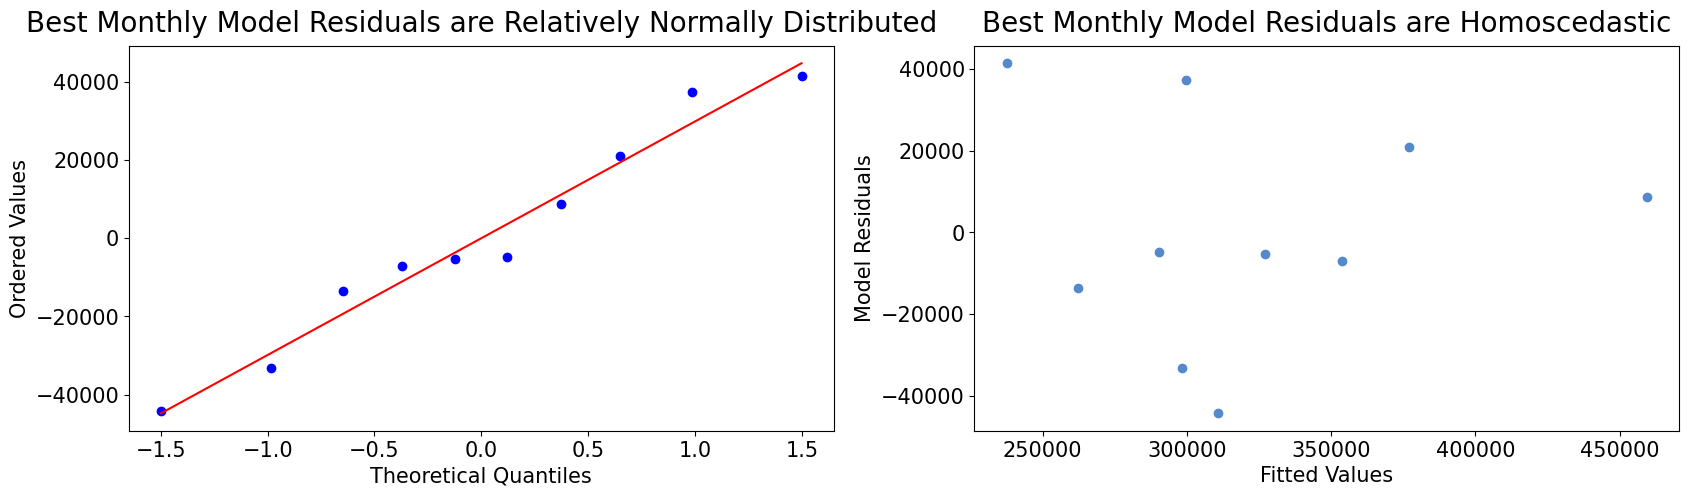

In [293]:
# To plot the residuals distribution 
plt.figure()
plt.subplots(1,2, figsize = (20,5))

# A histogram of the model residuals is plotted
plt.subplot(1,2,1)
stats.probplot(model_resids, dist='norm', plot = plt)
plt.title('Best Monthly Model Residuals are Relatively Normally Distributed', fontsize=20, pad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Theoretical Quantiles', fontsize=15)
plt.ylabel('Ordered Values', fontsize=15)

# A scatter plot of the model residuals vs fitted values is plotted
plt.subplot(1,2,2)
plt.scatter(model_fittedvals, model_resids,color = bakery.light_magpie)
plt.xlabel('Fitted Values', fontsize=15)
plt.ylabel('Model Residuals', fontsize=15)
plt.title('Best Monthly Model Residuals are Homoscedastic', fontsize=20, pad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

## Residual Observations
It can be seen from the above plots that the fitted values vs residuals are homoscedastic, which fits the assumptions made. The residual distribution though is not completely normal, and has a left-hand skew. However, this is not deemed significant and is most likely due to the small sample size used in fitting the model, therefore the model assumptions are met. 

---

# Summary 
The best models for each forecast are summarised in the table below, along with their MAPE scores and model number.

|Forecast| Model | MAPE |
|:--| :- | :- | 
|Daily|7| 7.7 %|
|Weekly|6| 9.9 %|
|Monthly|9| 13.3 %|

All of these models are now the leading and best models compared to the moving average models, which have their MAPE scores summarised below. 


|MAPE Score| Moving Average | Linear Regression | 
|:--| :- | :- | 
|Daily|20.7 %| 7.7 %|  
|Weekly |24.8 %| 9.9 %| 
|Monthly|17.0 %|13.3 %| 

Therefore, these are the current best forecasting models. 

---

# Further Improvements
Further improvements that could be made to the model is: 
- Applying Ridge and Lasso penalisation through a grid search to find the optimal hyperparameters for the model 
- Exploring different moving average window lengths to see if there is an optimum length (for example smaller window lengths will allow more data points to be included in the train dataset)
- Getting more data to impove fitting of the models, ideally at least 4 years worth 

# Next Steps
- A SARIMAX model will be developed for the daily forecast to see if this improves the accuracy from the linear regression and baseline models, found here [SARIMAX Model Notebook](8_Model_3_SARIMAX.ipynb)

# References
- **The Importance of the Normality Assumption in Large Public Health Data Sets**, Annual Review of Public Health, *https://www.annualreviews.org/doi/full/10.1146/annurev.publhealth.23.100901.140546#_i23*

>[Return to Contents](#Contents)